In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

## <b><u>Stat Sig Tests In Summary</b></u>
### <b><u>Prioritize Performance Metrics:</b></u> Focus on overall model performance to evaluate how well your model predicts outcomes.
### <b><u>Use Significance Tests as One Tool:</b></u> They can help identify which predictors might be important, 
### but they are not the only measure of a model’s effectiveness.
### <b><u>Consider Context and Practical Implications:</b></u> Think about whether a predictor is meaningful in the context of your specific problem, regardless of its statistical significance.

## Data descriptions:
doi: 10.24432/C5002N
<br><br>AP (Ambient Pressure) Feature,	Continuous, (range 992.89-1033.30 milibar)	units:milibar
<br>RH	(Residual Humidity) Feature,	Continuous, (range 25.56% to 100.16%)	units:%
<br>AT	(Ambient Temperature) Feature,	Continuous,	(range 1.81°C and 37.11°C)	units: C
<br>V (Exhaust Vacuum)	Feature	Continuous (range 25.36-81.56 cm Hg)        	units: cm Hg
<br><br>PE	(Net hourly electrical output of the plant) Target,	Continuous,	(range 420.26-495.76 MW)	units:MW
 
<b><u>combined cycle power plant:</b></u>
<br>-electricity of the plant is generated by steam,gas turbines, and returned heat
<br>-the vacuum is colected from and has effect on the steam turbine
<br>-ambient variables affect gas turbine performance


## Project goal:
use environment features to predict net hourly electrical energy output of the plant (EP)

In [2]:
df = pd.read_csv('CombinedCyclePowerPlant.csv', sep=',')
df.head()

AT      V       AP     RH      PE
0   8.34  40.77  1010.84  90.01  480.48
1  23.64  58.49  1011.40  74.20  445.75
2  29.74  56.90  1007.15  41.91  438.76
3  19.07  49.69  1007.22  76.79  453.09
4  11.80  40.66  1017.13  97.20  464.43

In [3]:
df.describe().T

count         mean        std     min        25%       50%      75%  \
AT  9568.0    19.651231   7.452473    1.81    13.5100    20.345    25.72   
V   9568.0    54.305804  12.707893   25.36    41.7400    52.080    66.54   
AP  9568.0  1013.259078   5.938784  992.89  1009.1000  1012.940  1017.26   
RH  9568.0    73.308978  14.600269   25.56    63.3275    74.975    84.83   
PE  9568.0   454.365009  17.066995  420.26   439.7500   451.550   468.43   

        max  
AT    37.11  
V     81.56  
AP  1033.30  
RH   100.16  
PE   495.76

Text(0.5, 1.0, 'PE (target) hist')

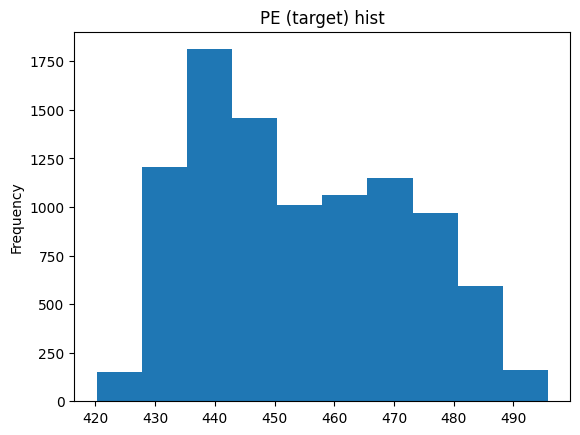

In [4]:
df['PE'].plot(kind='hist')
plt.title('PE (target) hist')

Text(0.5, 1.0, 'AP hist')

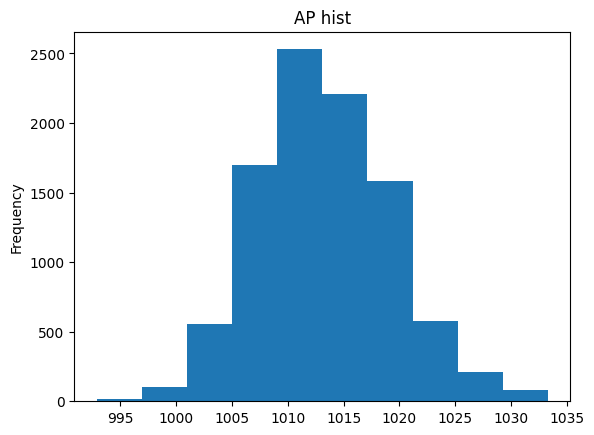

In [5]:
df['AP'].plot(kind='hist')
plt.title('AP hist')

Text(0.5, 1.0, 'RH hist')

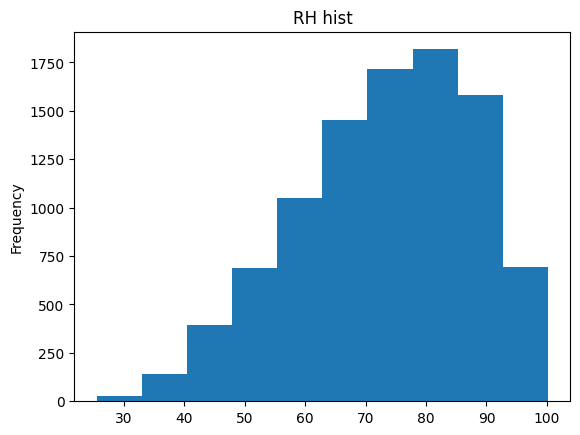

In [6]:
df['RH'].plot(kind='hist')
plt.title('RH hist')

Text(0.5, 1.0, 'AT hist')

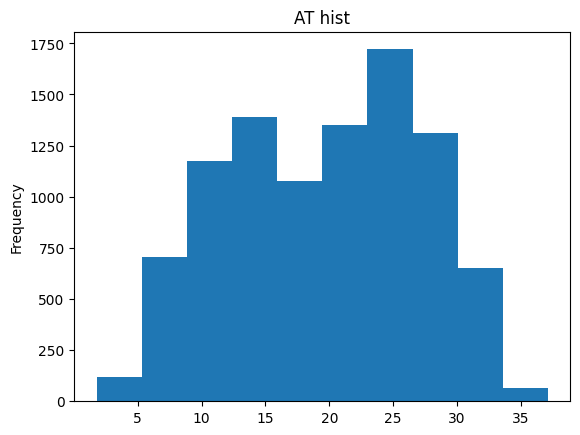

In [7]:
df['AT'].plot(kind='hist')
plt.title('AT hist')

Text(0.5, 1.0, 'V hist')

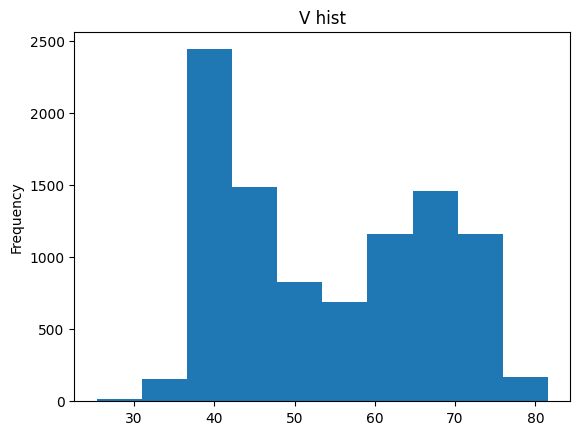

In [8]:
df['V'].plot(kind='hist')
plt.title('V hist')

Text(0.5, 1.0, 'RH hist')

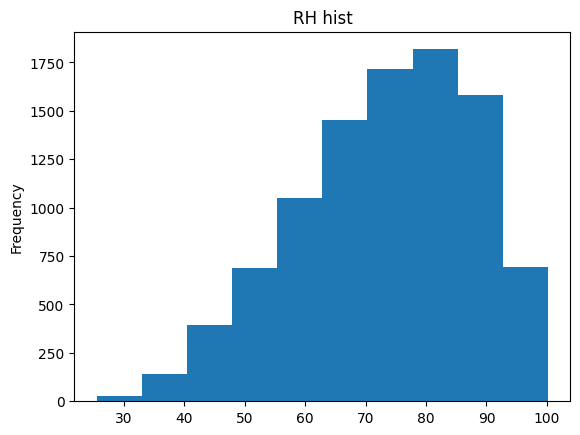

In [9]:
df['RH'].plot(kind='hist')
plt.title('RH hist')

In [10]:
df.isnull().describe()

AT      V     AP     RH     PE
count    9568   9568   9568   9568   9568
unique      1      1      1      1      1
top     False  False  False  False  False
freq     9568   9568   9568   9568   9568

In [11]:
import wolta
wolta.data_tools.col_types(df)

['float64', 'float64', 'float64', 'float64', 'float64']

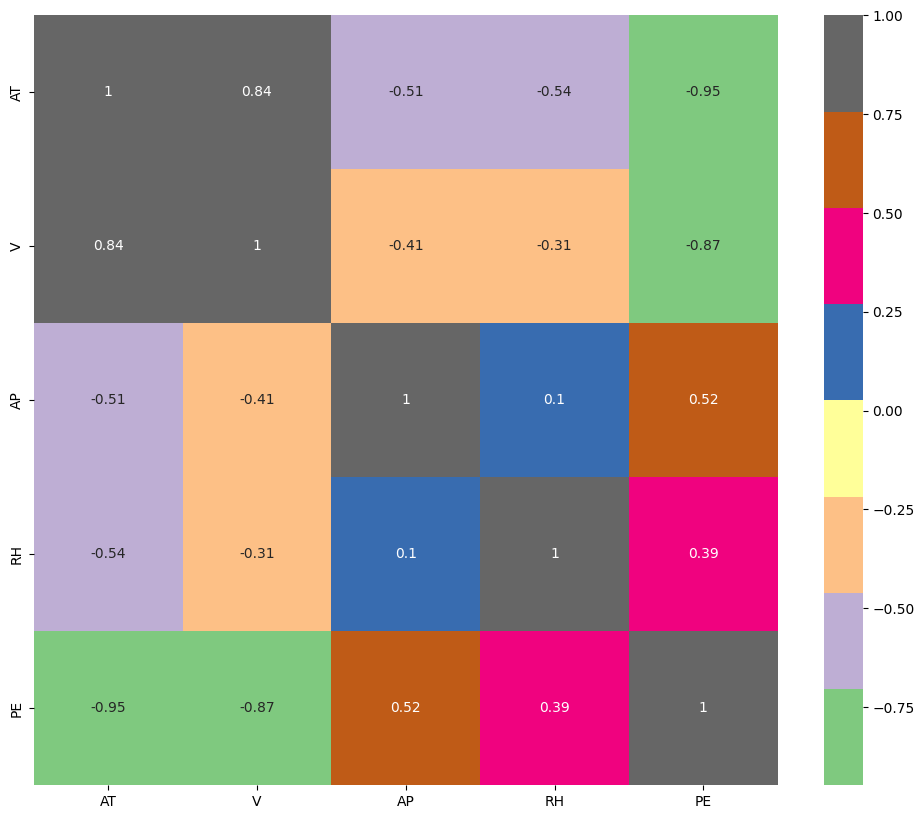

In [12]:
# pearson correlation
df.corr(method='pearson')
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Accent)
plt.show()

AP and PE: 0.52 (moderate corr)
<br>RH and PE: 0.39 (weark/moderate corr)
<br> V and PE: -0.87  (strong negative association to PE)
<br>AT and PE: -0.95 (strong negative association to PE)

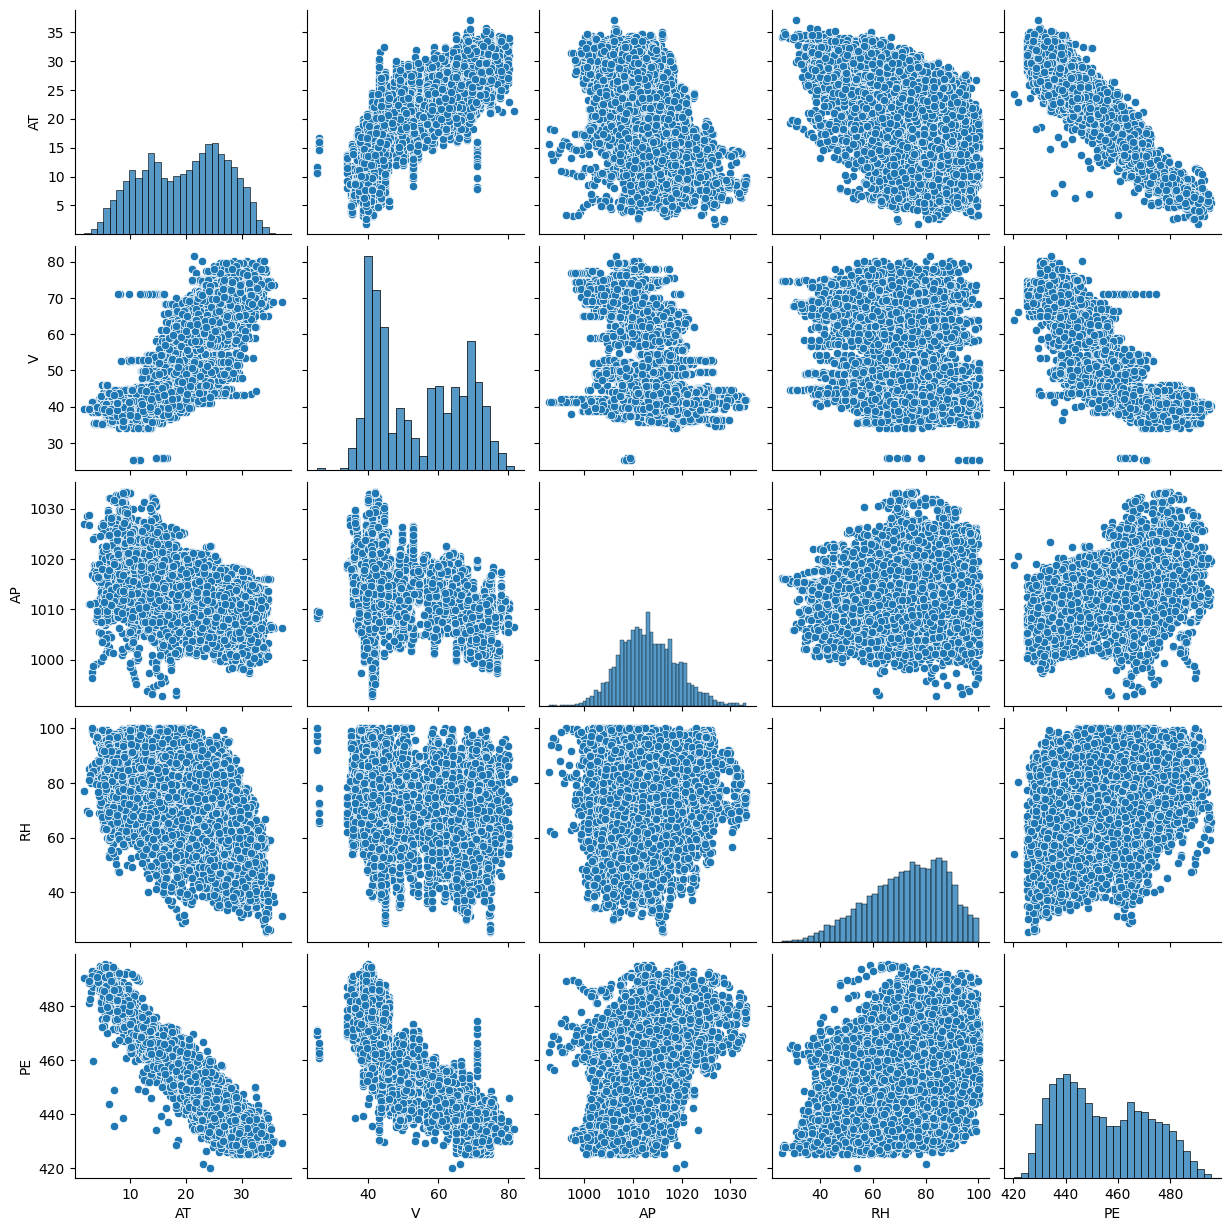

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
# Scatter plot to check relationships
sns.pairplot(df)
plt.show()

In [13]:
df['PE'].describe().to_frame().T

count        mean        std     min     25%     50%     75%     max
PE  9568.0  454.365009  17.066995  420.26  439.75  451.55  468.43  495.76

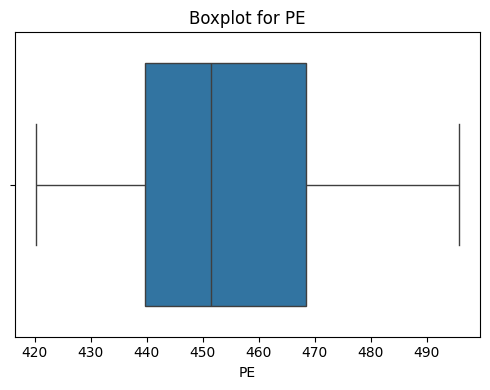

In [14]:
# Create boxplots for PE
plt.figure(figsize=(5, 4))
sns.boxplot(df['PE'], orient="h")
plt.title('Boxplot for PE')
plt.tight_layout()
plt.show()

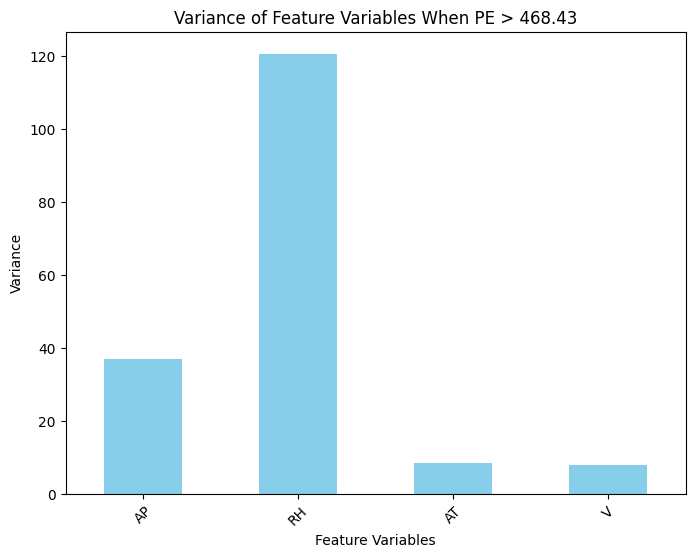

In [15]:
# Upper quartile of PE is 468.43
limit = 468.43

# Filter data where PE > 468.43
df_filtered = df[df['PE'] > limit]

# Calculate the variance of the feature variables in the filtered data
variance_values = df_filtered[['AP', 'RH', 'AT', 'V']].var()

# Create a bar chart of the variances
plt.figure(figsize=(8, 6))
variance_values.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title(f'Variance of Feature Variables When PE > {limit}')
plt.xlabel('Feature Variables')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.show()

# Multiple regression plots

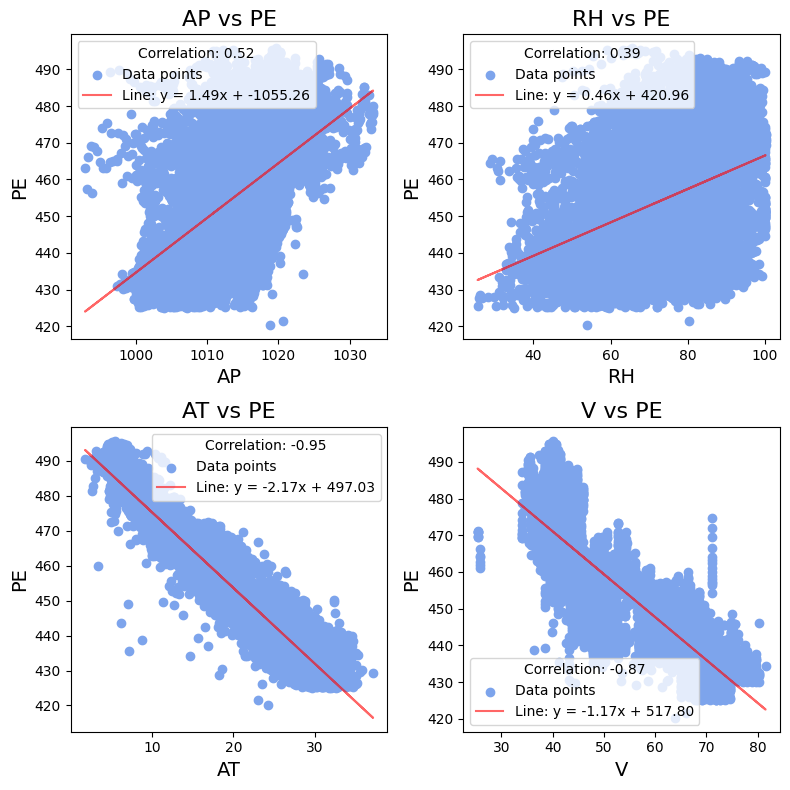

In [17]:
# Define the independent variables
independent_vars = ['AP', 'RH', 'AT', 'V']
y_name = 'PE'

# Create a figure for all plots
plt.figure(figsize=(8, 8)) # (height, width)

# Loop through independent variables and create plots
for i, x_name in enumerate(independent_vars):
    plt.subplot(2, 2, i + 1)  # 2x2 grid of plots
    x = df[x_name]
    y = df[y_name]
    
    plt.scatter(x, y, color='#7da4ec', label='Data points')
    
    # Fit a linear regression line (y = mx + b)
    m, b = np.polyfit(x, y, 1)
    
    # Plot the regression line
    plt.plot(x, m*x + b, color='red', alpha=0.6, label=f'Line: y = {m:.2f}x + {b:.2f}')
    
    # Calculate correlation
    correlation = np.corrcoef(x, y)[0, 1]
    
    # Add the correlation value to the legend
    plt.legend(title=f'Correlation: {correlation:.2f}')
    
    # Add labels and title
    plt.xlabel(x_name, size=14)
    plt.ylabel(y_name, size=14)
    plt.title(f'{x_name} vs {y_name}', size=16)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

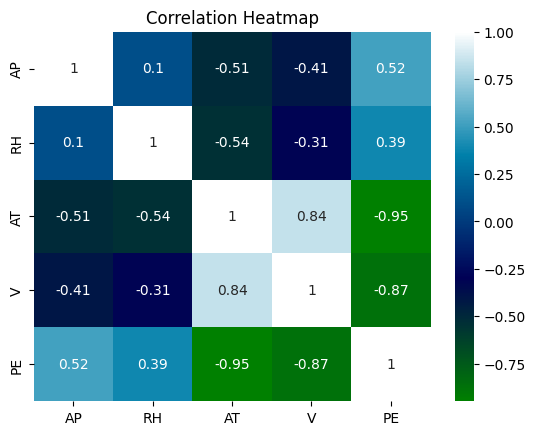

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[['AP', 'RH', 'AT', 'V', 'PE']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='ocean')
plt.title('Correlation Heatmap')
plt.show()

In [45]:
# Correlation of AT with other variables
corr_at = correlation_matrix['AT']

# Display correlations
print("Correlation of AT with other variables:")
print(corr_at)

Correlation of AT with other variables:
AP   -0.507549
RH   -0.542535
AT    1.000000
V     0.844107
PE   -0.948128
Name: AT, dtype: float64


# Boxplots

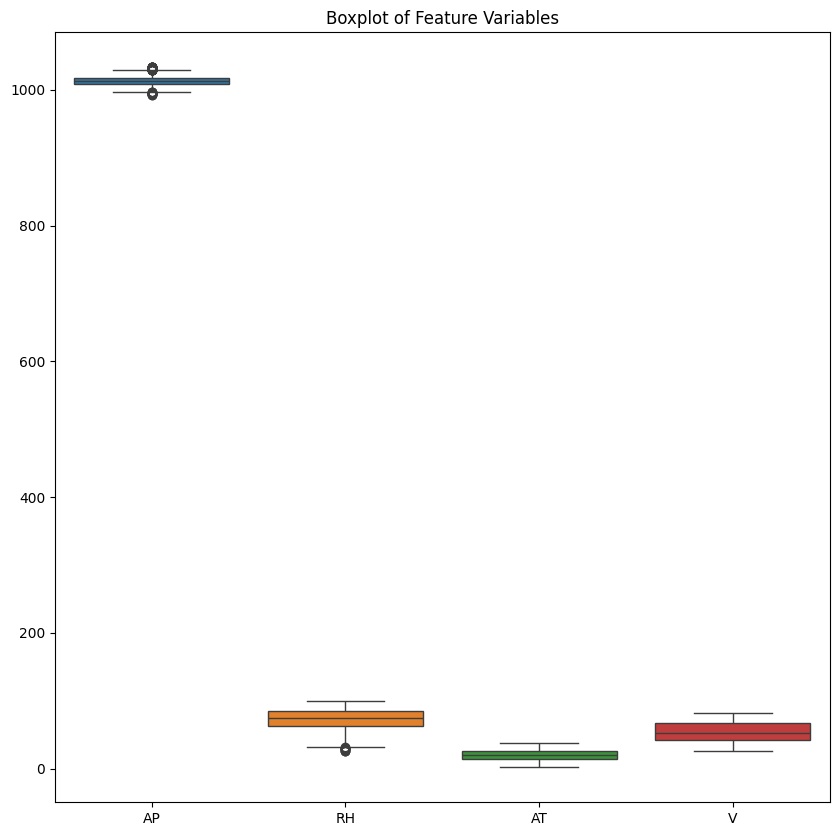

In [20]:
plt.figure(figsize=(10, 10))
# Boxplot to visualize outliers
sns.boxplot(data=df[['AP', 'RH', 'AT', 'V']])
plt.title('Boxplot of Feature Variables')
plt.show()

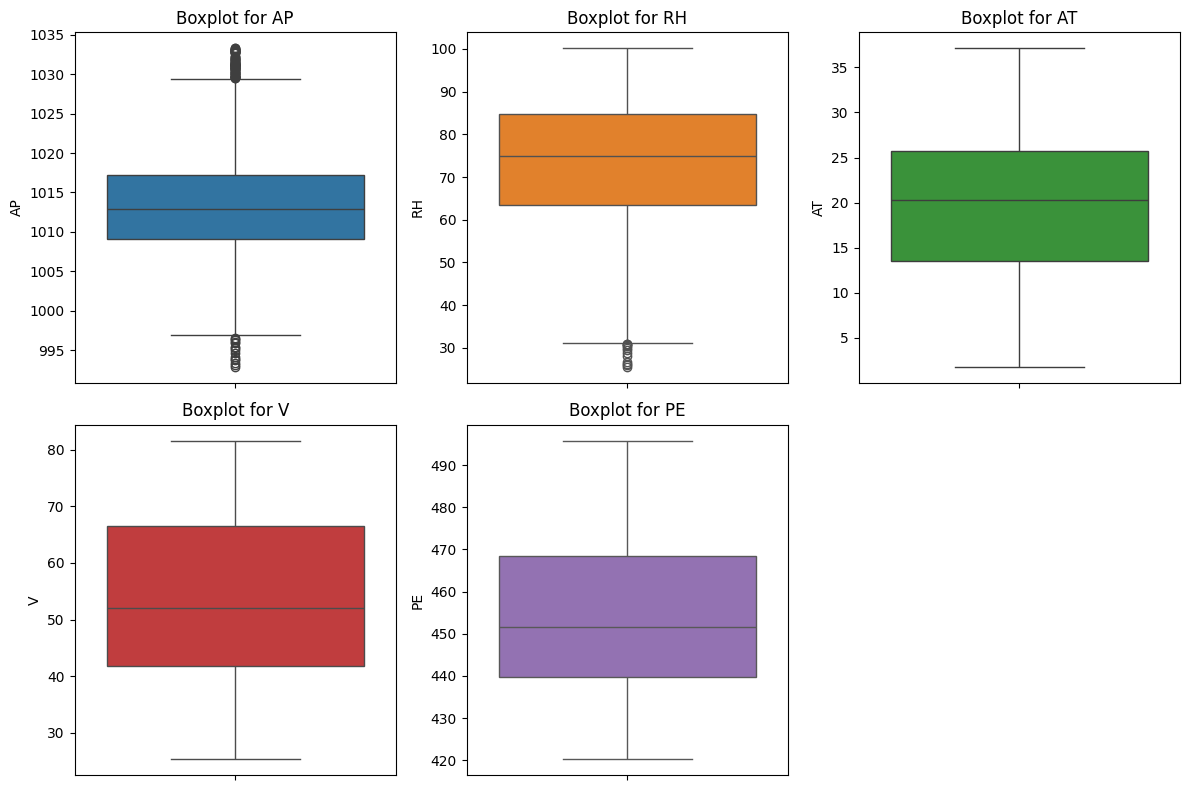

In [21]:
# Create a list of colors for each boxplot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # You can choose any colors you like

# Create boxplots for each feature variable
features = ['AP', 'RH', 'AT', 'V', 'PE']
plt.figure(figsize=(12, 8))

for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color=colors[i-1])  # Use different color for each boxplot
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

In [43]:
#global z score outlier removal method
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Define a function to remove global outliers based on Z-scores for the target variable
def remove_global_outliers_zscore(df, target, z_thresh=3):
    # Calculate the Z-scores for the 'PE' column across the entire dataset
    df['z_score'] = stats.zscore(df[target], nan_policy='omit')
    
    # Filter out rows where the absolute Z-score is greater than the threshold
    df_filtered = df[df['z_score'].abs() <= z_thresh]
    
    # Drop the 'z_score' column after filtering
    df_filtered = df_filtered.drop(columns=['z_score'])
    
    return df_filtered

# Create a copy of the original dataframe to remove outliers from
df_no_outliers = df.copy()

# Apply the global Z-score based outlier removal for 'PE'
df_no_outliers = remove_global_outliers_zscore(df_no_outliers, 'PE')

# Now df_no_outliers contains no outliers for PE based on global Z-scores

In [44]:
#further updated removal with z score 6:01pm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Define a function to remove outliers based on Z-scores for each binned feature
def remove_outliers_zscore(df, feature, target, z_thresh=3):
    # Group by the binned feature and calculate the Z-scores for 'PE' within each group
    df['z_score'] = df.groupby(feature)[target].transform(lambda x: stats.zscore(x, nan_policy='omit'))
    
    # Filter out rows where the absolute Z-score is greater than the threshold
    df_filtered = df[df['z_score'].abs() <= z_thresh]
    
    # Drop the 'z_score' column after filtering
    df_filtered = df_filtered.drop(columns=['z_score'])
    
    return df_filtered

# Create a copy of the original dataframe to remove outliers from
df_no_outliers = df.copy()

# Apply the Z-score based outlier removal for each binned feature
for feature in binned_features:
    df_no_outliers = remove_outliers_zscore(df_no_outliers, feature, 'PE')

# Now df_no_outliers contains no outliers for PE based on Z-scores

PE is better predicted when Boxplot of PE has less spread between bins.

## remove outliers step by step verification method:

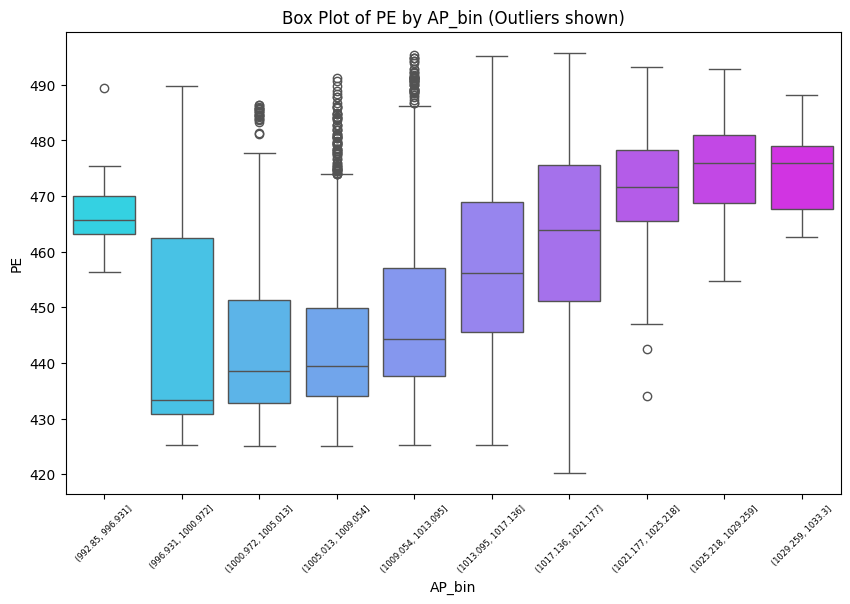

Outliers for AP_bin:
Count of outliers: 149



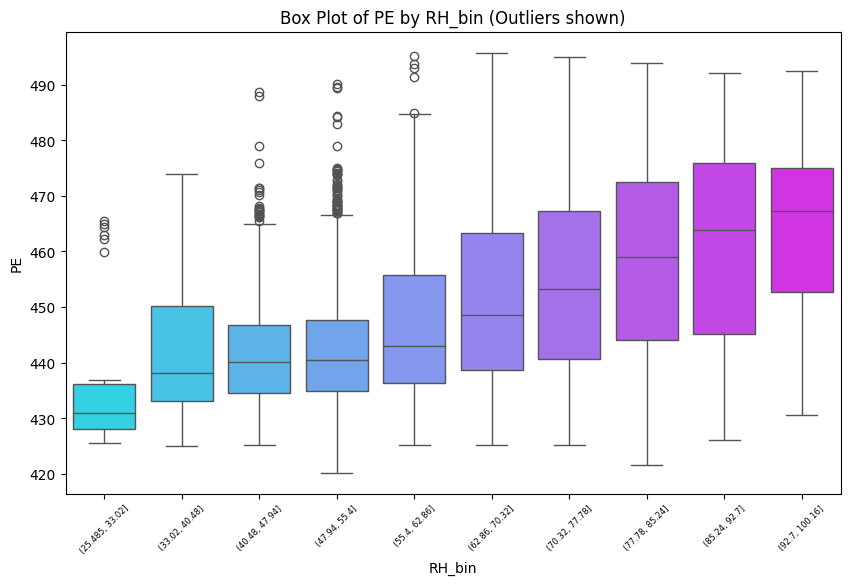

Outliers for RH_bin:
Count of outliers: 227



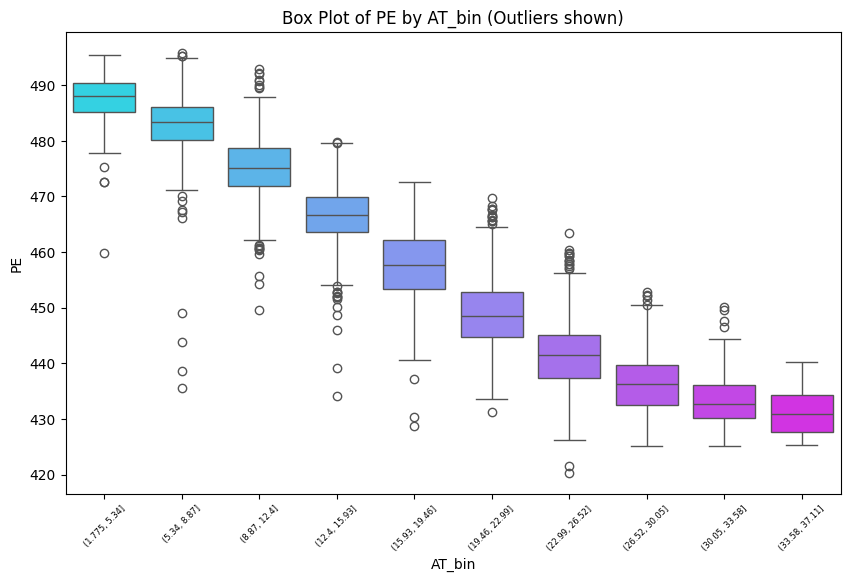

Outliers for AT_bin:
Count of outliers: 313



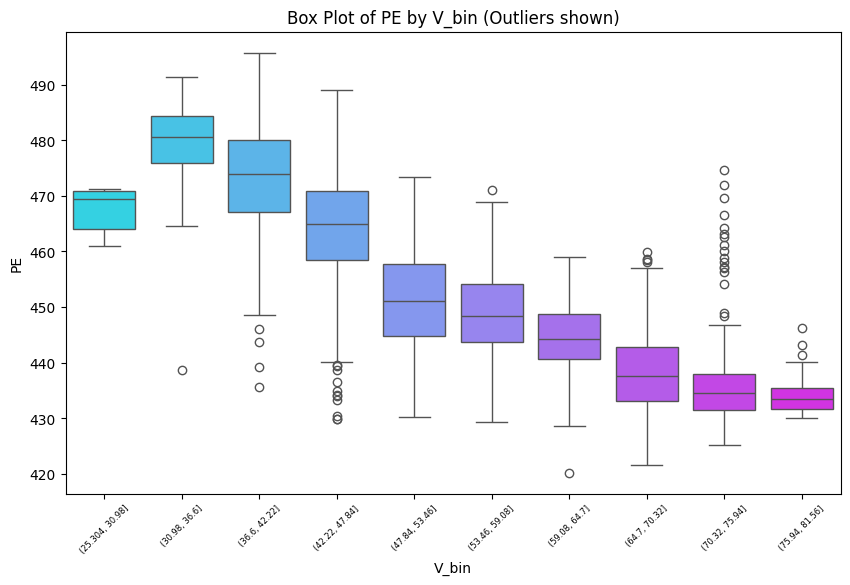

Outliers for V_bin:
Count of outliers: 349

Total number of outliers detected and removed: 366
Verifying removal of outliers...


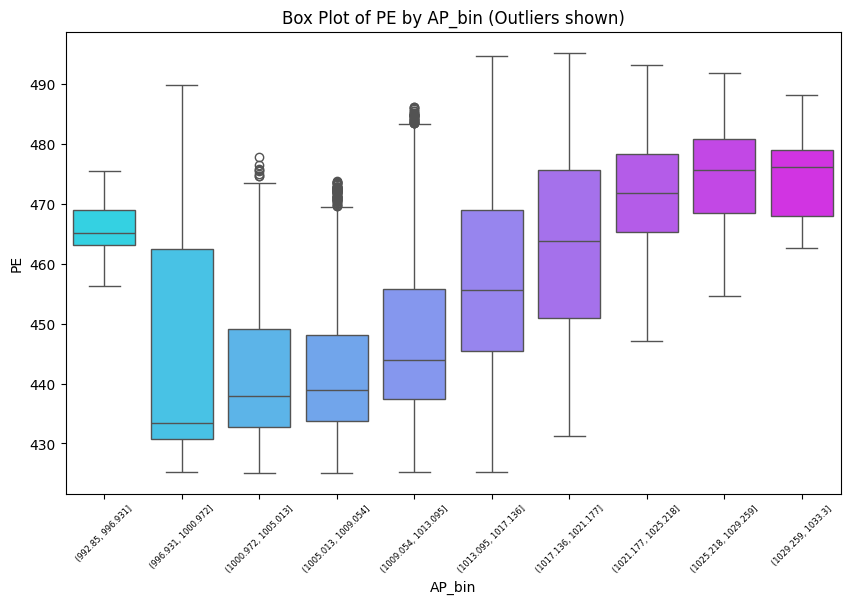

Outliers for AP_bin:
Count of outliers: 99

Remaining outliers for AP_bin: 99



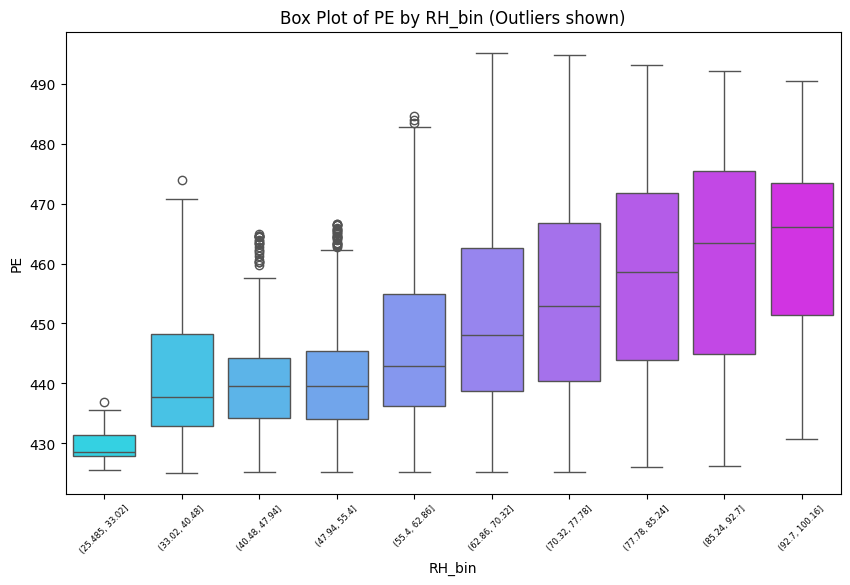

Outliers for RH_bin:
Count of outliers: 54

Remaining outliers for RH_bin: 54



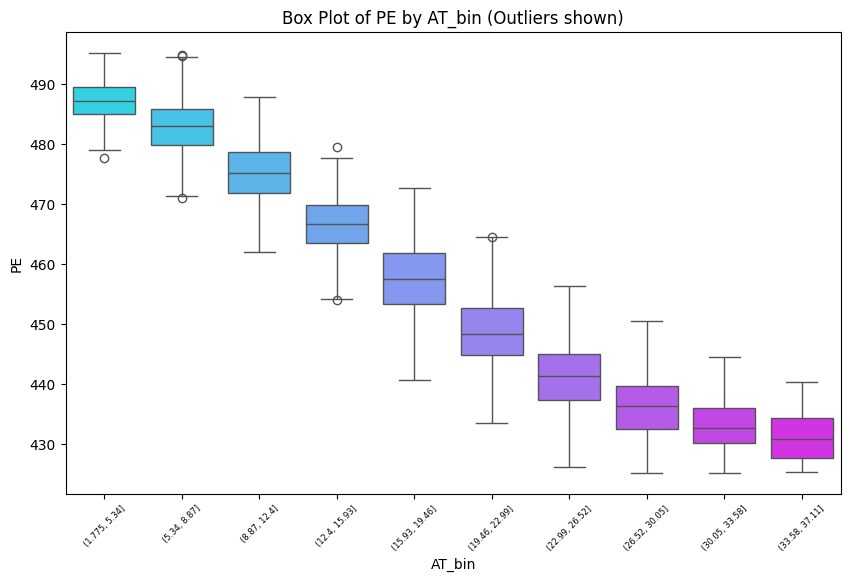

Outliers for AT_bin:
Count of outliers: 7

Remaining outliers for AT_bin: 7



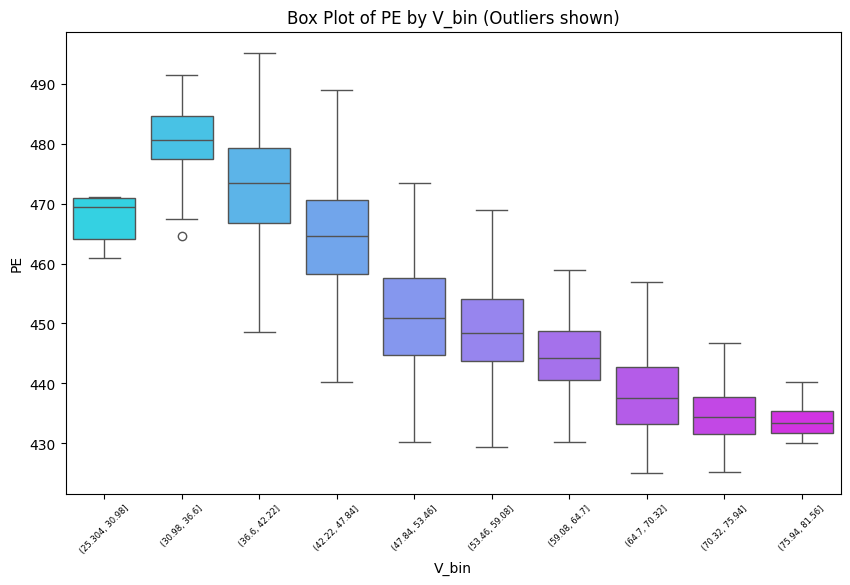

Outliers for V_bin:
Count of outliers: 1

Remaining outliers for V_bin: 1

Total remaining outliers after removal: 161


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create a function to find and return outlier indices across all binned features
def find_outliers_across_bins(df, features, target):
    all_outlier_indices = set()  # Use a set to ensure unique indices
    total_outliers_count = 0
    
    # Iterate through each binned feature
    for feature in features:
        # Group by the binned feature and calculate Q1, Q3, and IQR for the target variable (PE)
        grouped = df.groupby(feature)[target]
        Q1 = grouped.quantile(0.25)
        Q3 = grouped.quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate the bounds for detecting outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Iterate over the bins and find outliers
        for name, group in grouped:
            lower = lower_bound[name]
            upper = upper_bound[name]
            
            # Identify outliers in the group
            outliers = group[(group < lower) | (group > upper)]
            
            # Add outlier indices to the set (ensures no duplicates)
            all_outlier_indices.update(outliers.index.tolist())
            
            # Increment total outlier count
            total_outliers_count += len(outliers)
        
        # Display the plot with outliers for each feature
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=feature, y=target, data=df, palette='cool')
        plt.title(f'Box Plot of {target} by {feature} (Outliers shown)')
        plt.xlabel(feature)
        plt.ylabel(f'{target}')
        plt.xticks(rotation=45, size=6)
        plt.show()
        
        # Print outliers information for this feature
        print(f"Outliers for {feature}:")
        print(f"Count of outliers: {len(all_outlier_indices)}\n")

    return list(all_outlier_indices), total_outliers_count

# Step 2: Apply outlier detection for all binned features in one go
all_outliers, total_outliers = find_outliers_across_bins(df, binned_features, 'PE')

# Step 3: Remove the outliers by excluding rows with these outlier indices
df_no_outliers = df.drop(index=all_outliers)

# Step 4: Verify by checking outlier counts after removal
print(f"Total number of outliers detected and removed: {total_outliers}")
print("Verifying removal of outliers...")

# Step 5: Re-apply outlier detection to verify no remaining outliers
remaining_outliers_info = {}
total_remaining_outliers = 0

for feature in binned_features:
    # Re-find outliers after removal
    remaining_outliers, remaining_count = find_outliers_across_bins(df_no_outliers, [feature], 'PE')
    
    # Store the remaining count
    remaining_outliers_info[feature] = {
        'remaining_outlier_indices': remaining_outliers,
        'remaining_outlier_count': remaining_count
    }
    
    total_remaining_outliers += remaining_count
    
    # Print the remaining outliers count for each feature
    print(f"Remaining outliers for {feature}: {remaining_count}\n")

print(f"Total remaining outliers after removal: {total_remaining_outliers}")

# The final dataframe without outliers is stored in 'df_no_outliers'

In [24]:
import pandas as pd

# Step 1: Define a function to find remaining outliers and return their indices
def get_remaining_outliers_indices(df, features, target, multiplier=1.5):
    """
    Identify remaining outlier indices for the target variable across specified binned features.

    Parameters:
    df (DataFrame): The dataframe to check for outliers.
    features (list): List of binned feature names to check.
    target (str): The name of the target variable for which to find outliers.
    multiplier (float): The multiplier for IQR to define outliers (default is 1.5).

    Returns:
    list: A list of unique indices of the remaining outliers.
    """
    remaining_outlier_indices = set()  # Use a set to ensure unique indices

    # Iterate through each binned feature to identify outliers
    for feature in features:
        grouped = df.groupby(feature)[target]
        Q1 = grouped.quantile(0.25)
        Q3 = grouped.quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate the bounds for detecting outliers using the provided multiplier
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        for name, group in grouped:
            lower = lower_bound[name]
            upper = upper_bound[name]
            
            # Identify outliers in the group
            outliers = group[(group < lower) | (group > upper)]
            
            # Add outlier indices to the set
            remaining_outlier_indices.update(outliers.index.tolist())

    return list(remaining_outlier_indices)

# Step 2: Get the indices of the remaining outliers from df_outliers_removed
remaining_outliers_indices = get_remaining_outliers_indices(df_outliers_removed, binned_features, 'PE', multiplier=4.5)

# Print the count and indices of remaining outliers
print(f"Total remaining outliers found: {len(remaining_outliers_indices)}")
print(f"Indices of remaining outliers: {remaining_outliers_indices}\n")

# Step 3: Remove the remaining outliers from the dataframe
df_outliers_removed_final = df_outliers_removed.drop(index=remaining_outliers_indices)

# Step 4: Verify by checking outlier counts after final removal
remaining_outliers_final_info = {}
total_remaining_outliers_final = 0

# Check for remaining outliers in the final dataframe
for feature in binned_features:
    remaining_outliers = get_remaining_outliers_indices(df_outliers_removed_final, [feature], 'PE', multiplier=4.5)
    
    remaining_outliers_final_info[feature] = {
        'remaining_outlier_indices': remaining_outliers,
        'remaining_outlier_count': len(remaining_outliers)
    }
    
    total_remaining_outliers_final += len(remaining_outliers)
    
    # Print the remaining outliers count for each feature
    print(f"Remaining outliers for {feature}: {len(remaining_outliers)}\n")

print(f"Total remaining outliers after final removal: {total_remaining_outliers_final}")

# Final dataframe without any outliers is stored in 'df_outliers_removed_final'

Total remaining outliers found: 0
Indices of remaining outliers: []

Remaining outliers for AP_bin: 0

Remaining outliers for RH_bin: 0

Remaining outliers for AT_bin: 0

Remaining outliers for V_bin: 0

Total remaining outliers after final removal: 0


# Without PE outliers ( original iqr method)

In [5]:
# Define a function to remove outliers based on IQR for a given feature and target
def remove_outliers(df, feature, target):
    Q1 = df.groupby(feature)[target].quantile(0.25)
    Q3 = df.groupby(feature)[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.0 * IQR
    upper_bound = Q3 + 1.0 * IQR
    
    # Merge the bounds into the original dataframe
    bounds_df = pd.DataFrame({'lower_bound': lower_bound, 'upper_bound': upper_bound})
    df = df.merge(bounds_df, how='left', left_on=feature, right_index=True)
    
    # Filter out the outliers
    df_filtered = df[(df[target] >= df['lower_bound']) & (df[target] <= df['upper_bound'])]
    
    # Drop the columns with bounds
    df_filtered = df_filtered.drop(['lower_bound', 'upper_bound'], axis=1)
    
    return df_filtered

# Create a copy of the original dataframe to remove outliers from
df_no_outliers = df.copy()

# Apply the outlier removal for each binned feature iteratively
for feature in binned_features:
    df_no_outliers = remove_outliers(df_no_outliers, feature, 'PE')

# Now df_no_outliers contains no outliers for PE across all binned features

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to remove global outliers for PE based on IQR
def remove_global_outliers(df, target):
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers
    df_filtered = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)]
    
    return df_filtered

# Create a copy of the original dataframe to remove outliers from
df_no_outliers = df.copy()

# Remove global outliers for the 'PE' column
df_no_outliers = remove_global_outliers(df_no_outliers, 'PE')

# Now df_no_outliers contains no global PE outliers

# Plot with outliers

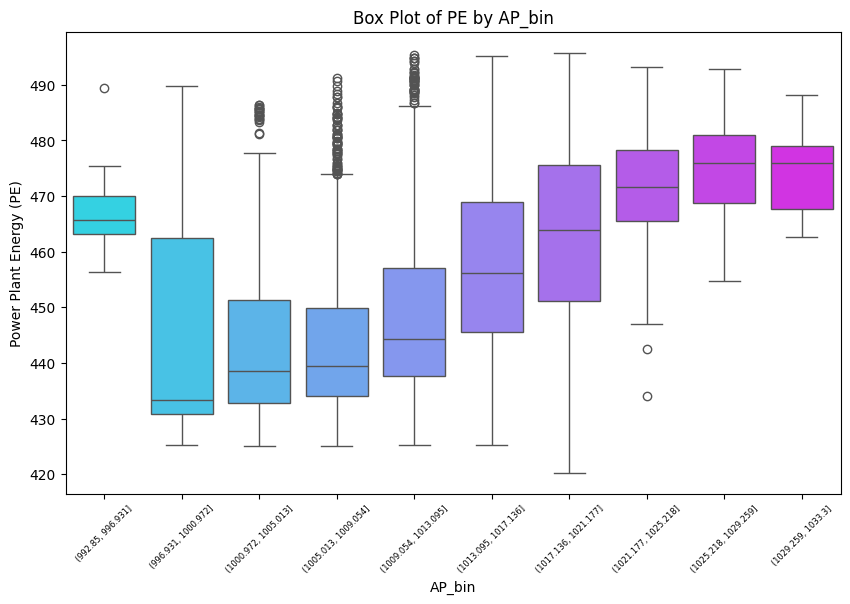

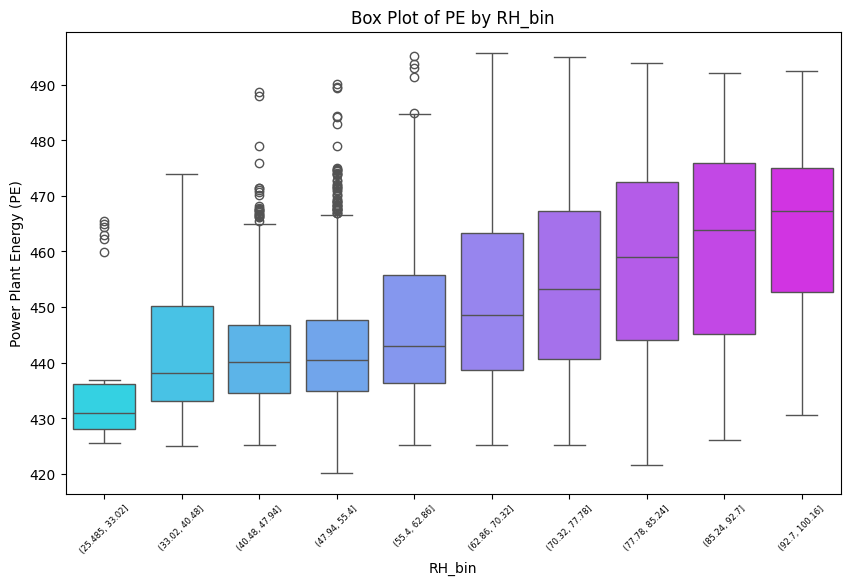

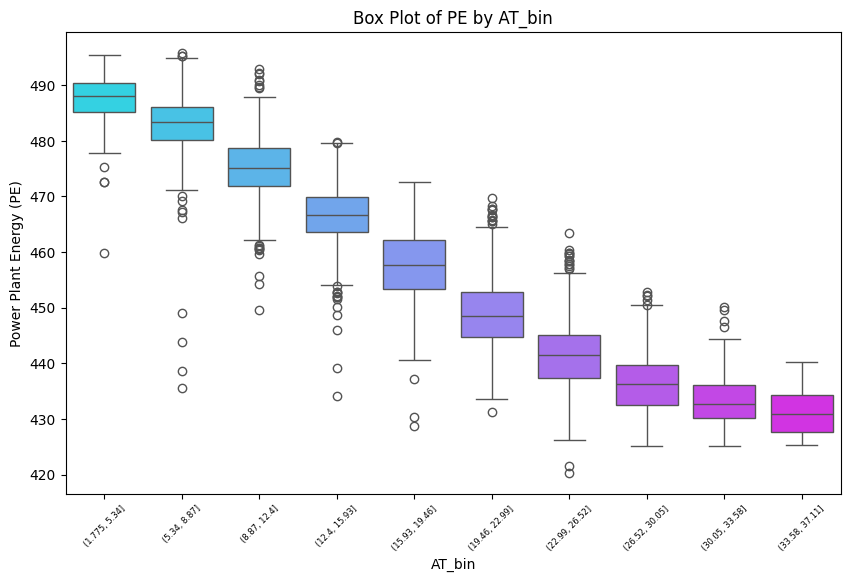

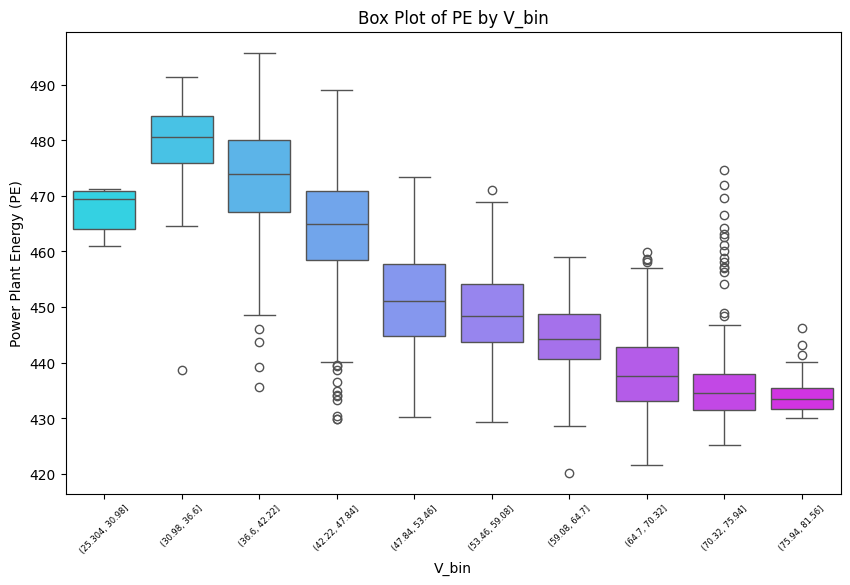

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature
# This example will categorize continuous features into bins.
df['AP_bin'] = pd.cut(df['AP'], bins=10)
df['RH_bin'] = pd.cut(df['RH'], bins=10)
df['AT_bin'] = pd.cut(df['AT'], bins=10)
df['V_bin'] = pd.cut(df['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Create box plots for each binned feature against PE
for feature in binned_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='PE', data=df, palette='cool')
    plt.title(f'Box Plot of PE by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45, size=6)
    plt.show()

# Plot no outliers

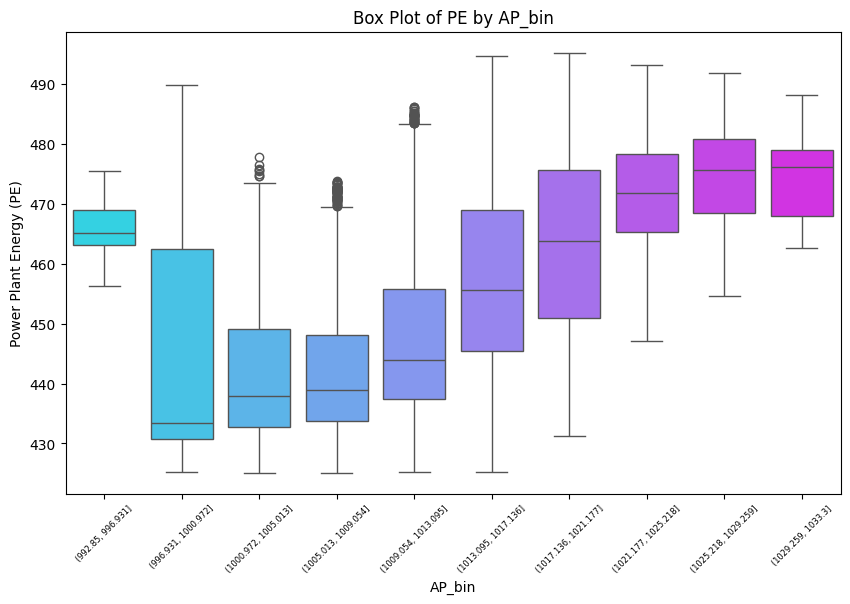

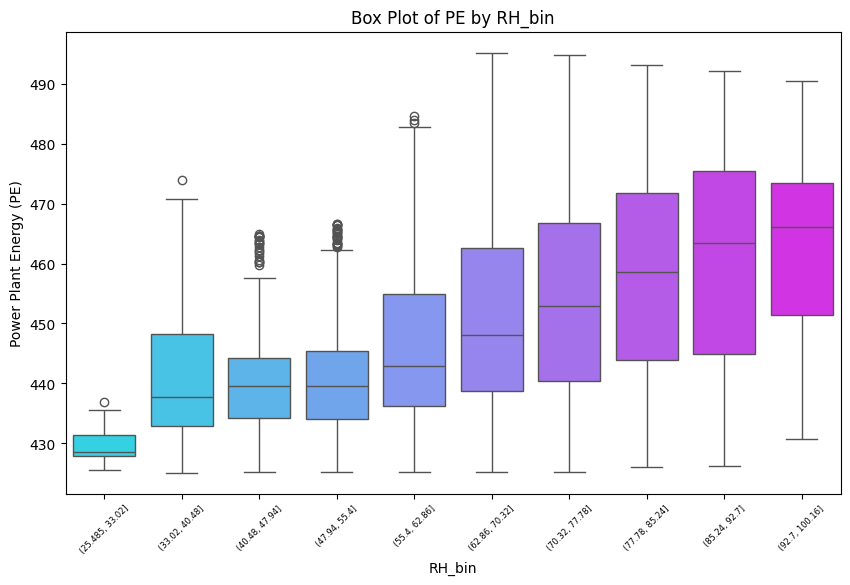

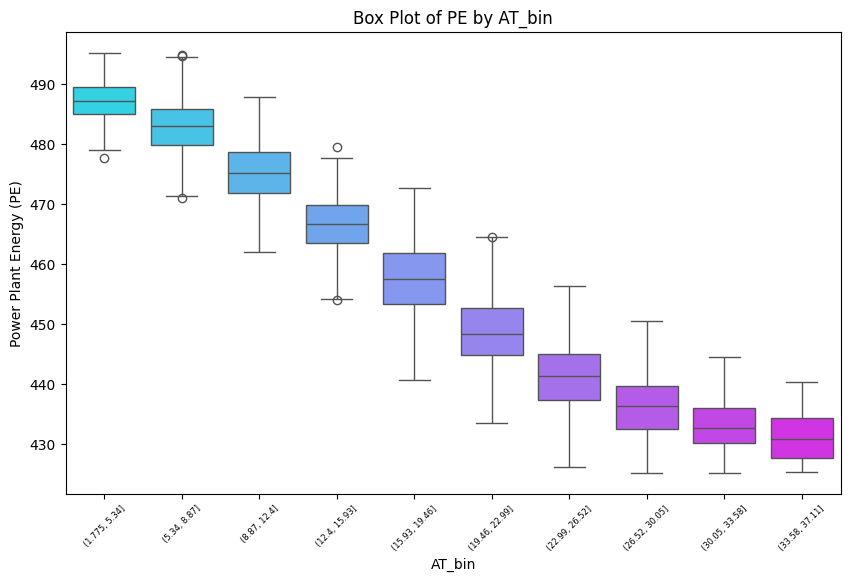

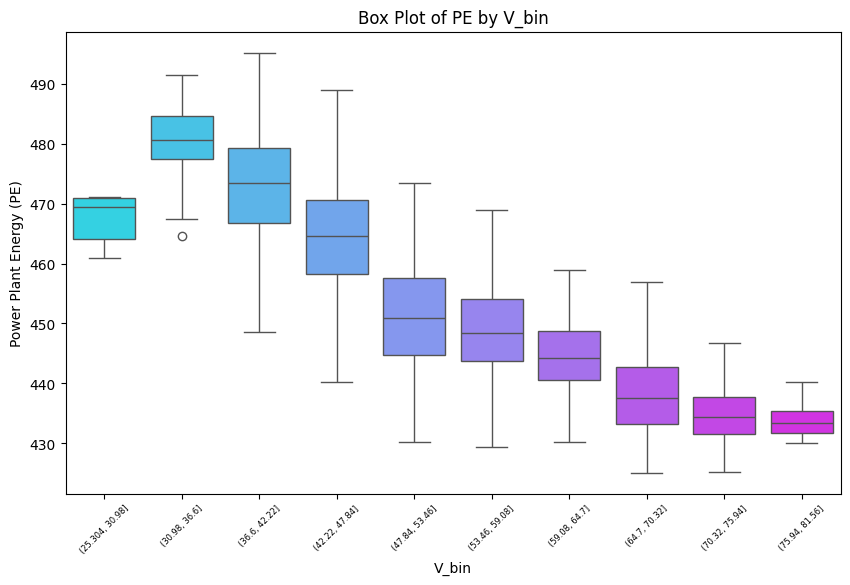

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature
# This example will categorize continuous features into bins.
df_outliers_removed_final['AP_bin'] = pd.cut(df_outliers_removed_final['AP'], bins=10)
df_outliers_removed_final['RH_bin'] = pd.cut(df_outliers_removed_final['RH'], bins=10)
df_outliers_removed_final['AT_bin'] = pd.cut(df_outliers_removed_final['AT'], bins=10)
df_outliers_removed_final['V_bin'] = pd.cut(df_outliers_removed_final['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Create box plots for each binned feature against PE
for feature in binned_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='PE', data=df_outliers_removed_final, palette='cool')
    plt.title(f'Box Plot of PE by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45, size=6)
    plt.show()

Outliers for AP_bin: Count = 99
Indices of outliers: [405, 1667, 4443, 5510, 6445, 7970, 8699, 9224, 167, 176, 300, 540, 733, 777, 891, 963, 1013, 1403, 1434, 1729, 1910, 2008, 2074, 2192, 2413, 2600, 2733, 2749, 2908, 3001, 3093, 3193, 3252, 3422, 3715, 3865, 3928, 3958, 3962, 4057, 4211, 4722, 5178, 5776, 5818, 5950, 6081, 6132, 6188, 6218, 6239, 6273, 6447, 6457, 6490, 6682, 7155, 7231, 7539, 7553, 8258, 8445, 8504, 8702, 8853, 9211, 9507, 9554, 675, 1046, 1389, 1598, 1964, 2105, 2163, 3579, 3693, 3901, 4074, 4480, 4706, 4822, 5507, 5826, 5946, 6072, 6143, 6326, 6665, 6745, 6787, 6983, 7696, 7856, 8140, 8382, 8696, 9167, 9522]



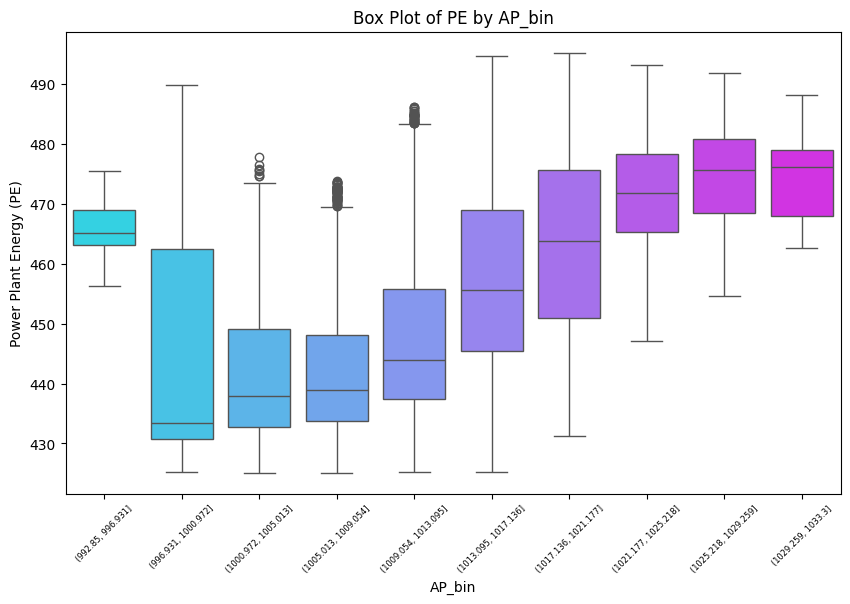

Outliers for RH_bin: Count = 54
Indices of outliers: [5013, 9211, 16, 1162, 1775, 3075, 3173, 3538, 3598, 4256, 4413, 4743, 4858, 5246, 5401, 5813, 6684, 7532, 8118, 8611, 8705, 8741, 8950, 9547, 992, 1517, 1779, 2238, 2419, 2521, 2605, 2721, 3317, 3844, 3878, 4106, 4342, 5148, 5180, 5609, 5760, 6337, 7188, 7369, 7596, 8112, 8192, 8988, 9151, 9210, 9282, 276, 7450, 7789]



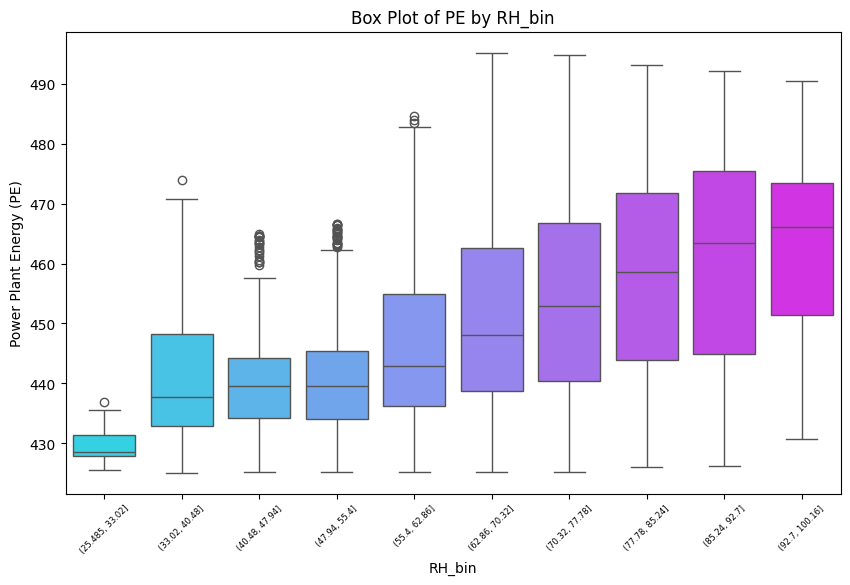

Outliers for AT_bin: Count = 7
Indices of outliers: [1060, 3062, 6734, 9200, 3438, 7721, 8570]



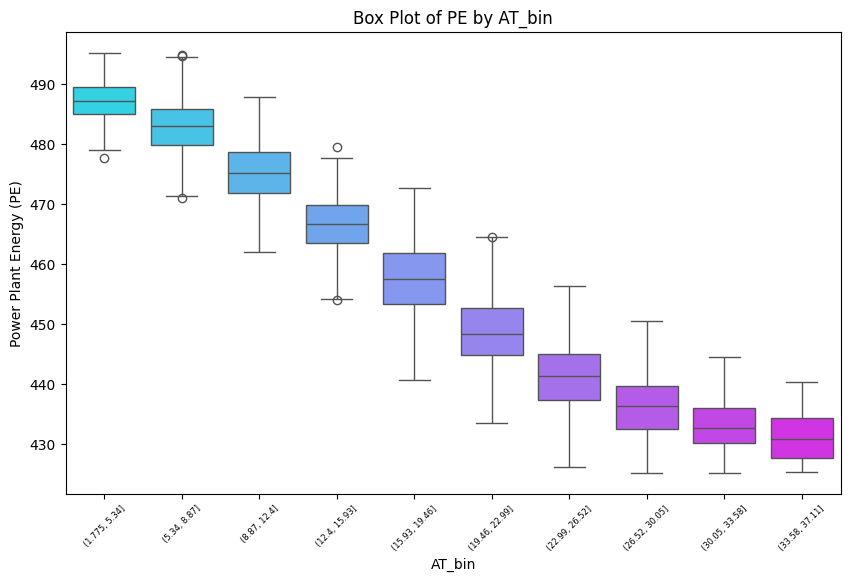

Outliers for V_bin: Count = 1
Indices of outliers: [3457]



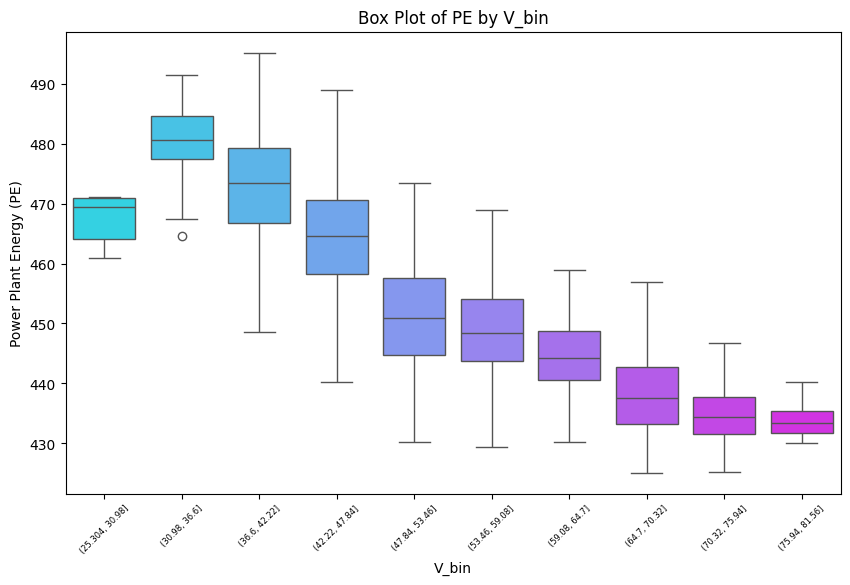

Remaining outliers after removal:

Remaining outliers for AP_bin: Count = 100
Indices of remaining outliers: [921, 1745, 5384, 5551, 6086, 7872, 8718, 8830, 9131, 258, 737, 1384, 1394, 1505, 1812, 1844, 2115, 2235, 2700, 2748, 2832, 3239, 3310, 3520, 3553, 3820, 3824, 4015, 4339, 4365, 4387, 5000, 5430, 5465, 5555, 5673, 5914, 6022, 6083, 7358, 7499, 7515, 7549, 7552, 7577, 8009, 8189, 8541, 8806, 8867, 8883, 9048, 9054, 9360, 134, 751, 792, 1096, 1191, 1312, 1559, 1612, 1673, 1732, 2454, 2530, 2533, 2686, 3258, 3313, 3350, 3511, 4264, 4279, 4487, 4821, 5349, 5452, 5524, 5739, 5865, 6362, 6949, 7126, 7161, 7913, 7955, 8003, 8073, 8110, 8313, 8322, 8497, 8638, 8723, 9070, 9182, 9185, 9328, 9473]

Remaining outliers for RH_bin: Count = 17
Indices of remaining outliers: [1720, 3169, 3541, 3704, 4336, 6563, 7453, 8304, 801, 6130, 7335, 7694, 6037, 6379, 7814, 8814, 3004]

Remaining outliers for AT_bin: Count = 5
Indices of remaining outliers: [1016, 4405, 5796, 4862, 5352]

Remaining outli

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature
df_outliers_removed_final['AP_bin'] = pd.cut(df_outliers_removed_final['AP'], bins=10)
df_outliers_removed_final['RH_bin'] = pd.cut(df_outliers_removed_final['RH'], bins=10)
df_outliers_removed_final['AT_bin'] = pd.cut(df_outliers_removed_final['AT'], bins=10)
df_outliers_removed_final['V_bin'] = pd.cut(df_outliers_removed_final['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Function to count outliers
def count_outliers(df, feature, target):
    grouped = df.groupby(feature)[target]
    Q1 = grouped.quantile(0.25)
    Q3 = grouped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = []

    for name, group in grouped:
        lower = lower_bound[name]
        upper = upper_bound[name]
        # Identify outliers in the group
        outliers = group[(group < lower) | (group > upper)]
        outlier_indices.extend(outliers.index.tolist())
    
    return outlier_indices

# Count and print outliers for each feature
outliers_summary = {}

for feature in binned_features:
    outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    outliers_summary[feature] = outlier_indices
    print(f"Outliers for {feature}: Count = {len(outlier_indices)}")
    print(f"Indices of outliers: {outlier_indices}\n")

    # Create box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='PE', data=df_outliers_removed_final, palette='cool')
    plt.title(f'Box Plot of PE by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45, size=6)
    plt.show()

# Remove outliers from df_outliers_removed_final
all_outlier_indices = set().union(*outliers_summary.values())
df_outliers_removed_final = df_outliers_removed_final.drop(index=all_outlier_indices)

# Re-check for remaining outliers in the updated DataFrame
print("Remaining outliers after removal:\n")
for feature in binned_features:
    remaining_outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    print(f"Remaining outliers for {feature}: Count = {len(remaining_outlier_indices)}")
    print(f"Indices of remaining outliers: {remaining_outlier_indices}\n")

Outliers for AP_bin: Count = 100
Indices of outliers: [921, 1745, 5384, 5551, 6086, 7872, 8718, 8830, 9131, 258, 737, 1384, 1394, 1505, 1812, 1844, 2115, 2235, 2700, 2748, 2832, 3239, 3310, 3520, 3553, 3820, 3824, 4015, 4339, 4365, 4387, 5000, 5430, 5465, 5555, 5673, 5914, 6022, 6083, 7358, 7499, 7515, 7549, 7552, 7577, 8009, 8189, 8541, 8806, 8867, 8883, 9048, 9054, 9360, 134, 751, 792, 1096, 1191, 1312, 1559, 1612, 1673, 1732, 2454, 2530, 2533, 2686, 3258, 3313, 3350, 3511, 4264, 4279, 4487, 4821, 5349, 5452, 5524, 5739, 5865, 6362, 6949, 7126, 7161, 7913, 7955, 8003, 8073, 8110, 8313, 8322, 8497, 8638, 8723, 9070, 9182, 9185, 9328, 9473]



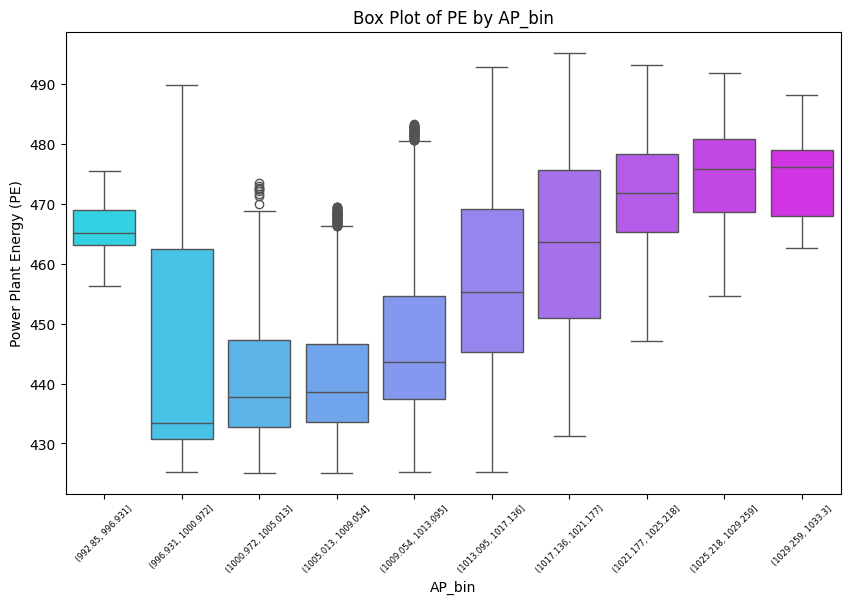

Outliers for RH_bin: Count = 17
Indices of outliers: [1720, 3169, 3541, 3704, 4336, 6563, 7453, 8304, 801, 6130, 7335, 7694, 6037, 6379, 7814, 8814, 3004]



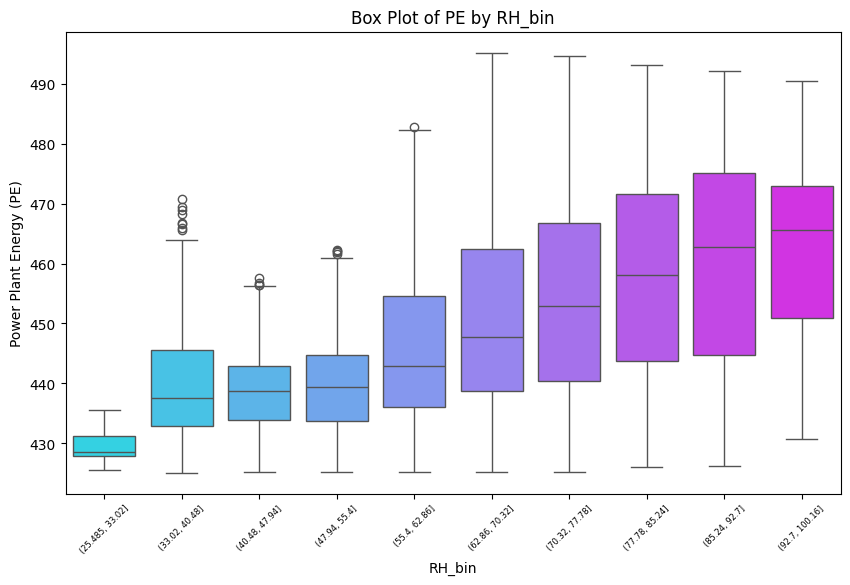

Outliers for AT_bin: Count = 5
Indices of outliers: [1016, 4405, 5796, 4862, 5352]



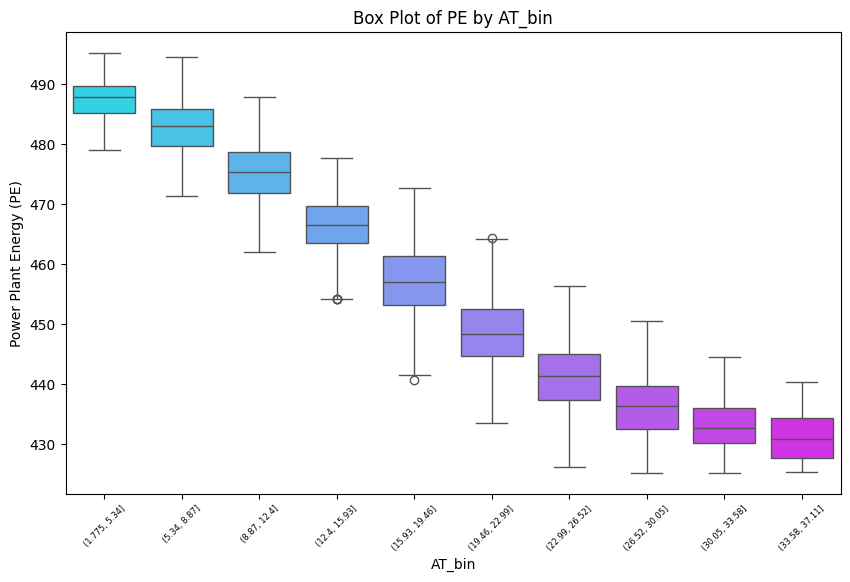

Outliers for V_bin: Count = 0
Indices of outliers: []



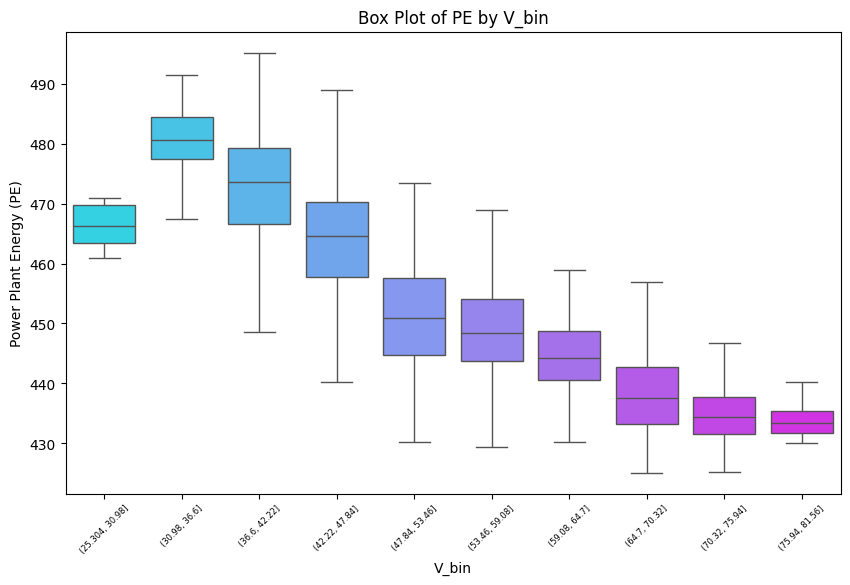

Remaining outliers after initial removal:

Remaining outliers for AP_bin: Count = 134
Indices of remaining outliers: [693, 700, 864, 1017, 1255, 2090, 2179, 3550, 3903, 4381, 4544, 5237, 5554, 6564, 6781, 7160, 7598, 8018, 8569, 9057, 55, 127, 510, 910, 1257, 1450, 1587, 1658, 2030, 2070, 2084, 2390, 2506, 2822, 2836, 2860, 2907, 3225, 3342, 3712, 4398, 4864, 5079, 5680, 5925, 6133, 6368, 6594, 6892, 7063, 7110, 7528, 7836, 7945, 7963, 7966, 8059, 8148, 8162, 8186, 8489, 8496, 8683, 8925, 9050, 9222, 9274, 9387, 9407, 9544, 0, 150, 279, 299, 459, 489, 642, 844, 1102, 1111, 1358, 1711, 1793, 2234, 2244, 2293, 2442, 2727, 2953, 2968, 3084, 3129, 3236, 3256, 3608, 3625, 3659, 3679, 3751, 4486, 4624, 4963, 5006, 5109, 5299, 5495, 5824, 5945, 5949, 6023, 6031, 6107, 6250, 6373, 6668, 6696, 7023, 7267, 7509, 7546, 7737, 7903, 8168, 8199, 8299, 8309, 8317, 8495, 8534, 8573, 8757, 8953, 9219, 9335]

Remaining outliers for RH_bin: Count = 16
Indices of remaining outliers: [42, 232, 469, 635, 32

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature
df_outliers_removed_final['AP_bin'] = pd.cut(df_outliers_removed_final['AP'], bins=10)
df_outliers_removed_final['RH_bin'] = pd.cut(df_outliers_removed_final['RH'], bins=10)
df_outliers_removed_final['AT_bin'] = pd.cut(df_outliers_removed_final['AT'], bins=10)
df_outliers_removed_final['V_bin'] = pd.cut(df_outliers_removed_final['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Function to count outliers
def count_outliers(df, feature, target):
    grouped = df.groupby(feature)[target]
    Q1 = grouped.quantile(0.25)
    Q3 = grouped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = []

    for name, group in grouped:
        lower = lower_bound[name]
        upper = upper_bound[name]
        # Identify outliers in the group
        outliers = group[(group < lower) | (group > upper)]
        outlier_indices.extend(outliers.index.tolist())
    
    return outlier_indices

# Count and print outliers for each feature
outliers_summary = {}

for feature in binned_features:
    outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    outliers_summary[feature] = outlier_indices
    print(f"Outliers for {feature}: Count = {len(outlier_indices)}")
    print(f"Indices of outliers: {outlier_indices}\n")

    # Create box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='PE', data=df_outliers_removed_final, palette='cool')
    plt.title(f'Box Plot of PE by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45, size=6)
    plt.show()

# Remove the identified outliers from df_outliers_removed_final
all_outlier_indices = set().union(*outliers_summary.values())
df_outliers_removed_final = df_outliers_removed_final.drop(index=all_outlier_indices)

# Re-check for remaining outliers in the updated DataFrame
print("Remaining outliers after initial removal:\n")
remaining_outliers_summary = {}

for feature in binned_features:
    remaining_outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    remaining_outliers_summary[feature] = remaining_outlier_indices
    print(f"Remaining outliers for {feature}: Count = {len(remaining_outlier_indices)}")
    print(f"Indices of remaining outliers: {remaining_outlier_indices}\n")

# Remove remaining outliers again from df_outliers_removed_final
final_outlier_indices = set().union(*remaining_outliers_summary.values())
df_outliers_removed_final = df_outliers_removed_final.drop(index=final_outlier_indices)

# Final check for any remaining outliers
print("Final remaining outliers after second removal:\n")
for feature in binned_features:
    final_remaining_outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    print(f"Final remaining outliers for {feature}: Count = {len(final_remaining_outlier_indices)}")
    print(f"Indices of final remaining outliers: {final_remaining_outlier_indices}\n")

Outliers for AP_bin: Count = 117
Indices of outliers: [46, 634, 1143, 1698, 3131, 3354, 4066, 4441, 4986, 5091, 5108, 6157, 6489, 6906, 6959, 215, 702, 766, 856, 1166, 1201, 1216, 1738, 1939, 2032, 2053, 2280, 2347, 3090, 3210, 3929, 4043, 4206, 4927, 4994, 5368, 5669, 5746, 5780, 5793, 6060, 6255, 6535, 6593, 6889, 7306, 7637, 7860, 8803, 103, 164, 234, 304, 429, 526, 564, 747, 833, 834, 905, 1229, 1238, 1272, 1284, 1359, 1487, 1530, 1710, 2040, 2077, 2100, 2134, 2142, 2160, 2336, 2867, 3160, 3459, 3485, 3497, 3665, 4318, 4354, 4640, 4793, 4840, 4850, 4885, 5376, 5433, 5556, 5611, 5735, 5802, 5859, 6247, 6414, 6551, 6626, 6859, 6864, 7118, 7119, 7127, 7459, 7573, 7652, 7774, 7972, 8641, 8670, 8739, 8976, 9135, 9155, 9343, 9479]



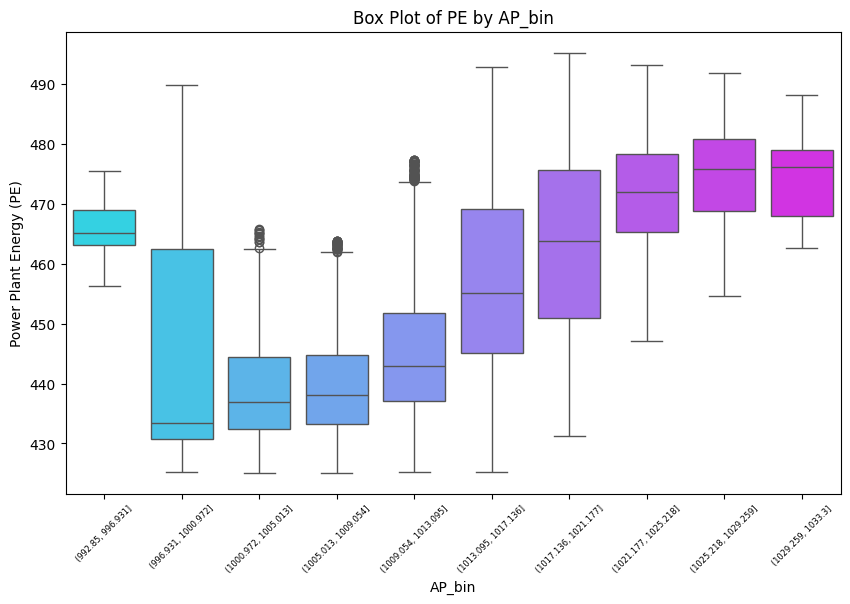

Outliers for RH_bin: Count = 2
Indices of outliers: [125, 3777]



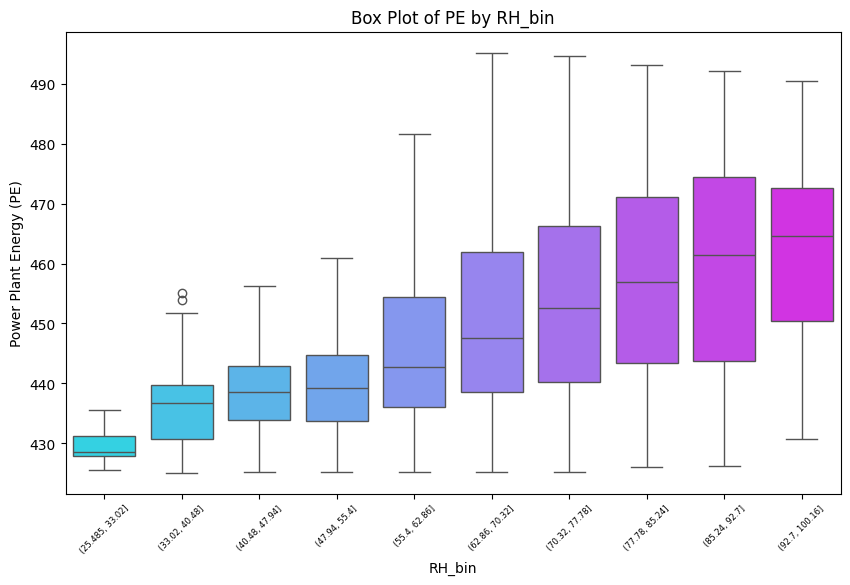

Outliers for AT_bin: Count = 5
Indices of outliers: [2532, 6487, 8567, 1454, 1748]



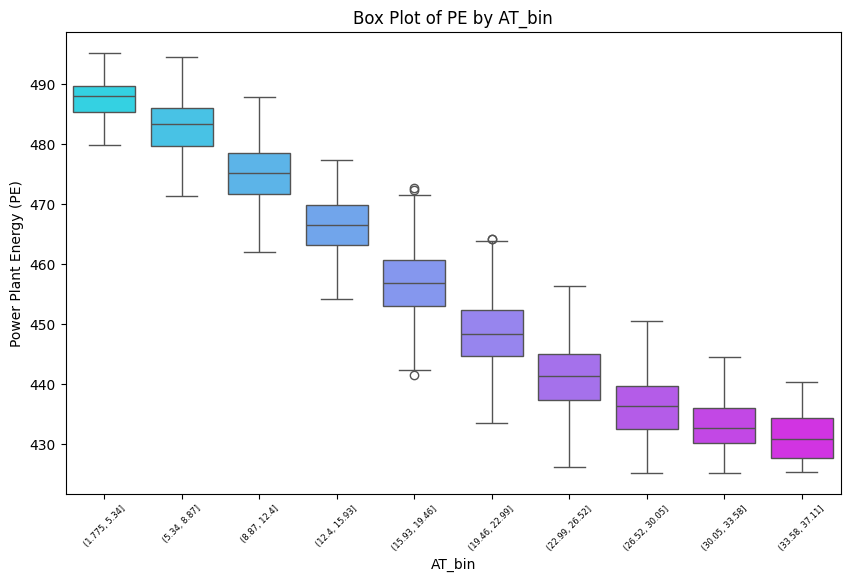

Outliers for V_bin: Count = 0
Indices of outliers: []



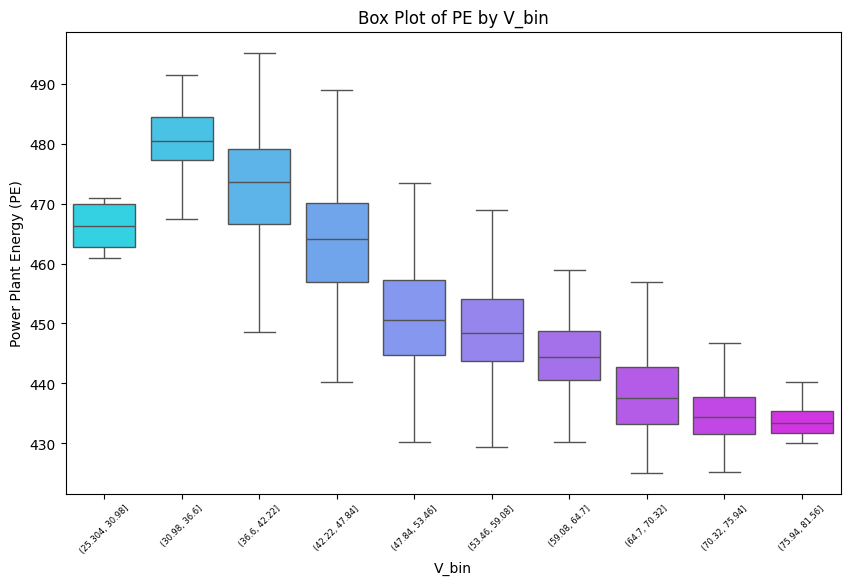

Remaining outliers after initial removal:

Remaining outliers for AP_bin: Count = 95
Indices of remaining outliers: [1428, 1545, 2174, 2310, 2389, 2731, 3583, 4809, 4911, 5393, 5399, 7607, 8165, 8731, 9342, 9420, 401, 2109, 2515, 2529, 2881, 2901, 5133, 6321, 6566, 7158, 7310, 8498, 8909, 8979, 9250, 114, 172, 739, 973, 1209, 1277, 1278, 1289, 1438, 1507, 1588, 2050, 2295, 2476, 2715, 2775, 2848, 3034, 3514, 3803, 3941, 4138, 4268, 4275, 4429, 4548, 4570, 4663, 4705, 4835, 4884, 5099, 5111, 5313, 5486, 5511, 5655, 5978, 6085, 6123, 6169, 6538, 6729, 6838, 6855, 6973, 7131, 7179, 7250, 7436, 7476, 7487, 8030, 8153, 8252, 8280, 8300, 8635, 8740, 8864, 9036, 9128, 9195, 9352]

Remaining outliers for RH_bin: Count = 6
Indices of remaining outliers: [994, 3450, 3961, 4574, 397, 1891]

Remaining outliers for AT_bin: Count = 3
Indices of remaining outliers: [1032, 9111, 126]

Remaining outliers for V_bin: Count = 2
Indices of remaining outliers: [6853, 7268]

Final remaining outliers after se

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature
df_outliers_removed_final['AP_bin'] = pd.cut(df_outliers_removed_final['AP'], bins=10)
df_outliers_removed_final['RH_bin'] = pd.cut(df_outliers_removed_final['RH'], bins=10)
df_outliers_removed_final['AT_bin'] = pd.cut(df_outliers_removed_final['AT'], bins=10)
df_outliers_removed_final['V_bin'] = pd.cut(df_outliers_removed_final['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Function to count outliers
def count_outliers(df, feature, target):
    grouped = df.groupby(feature)[target]
    Q1 = grouped.quantile(0.25)
    Q3 = grouped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = []

    for name, group in grouped:
        lower = lower_bound[name]
        upper = upper_bound[name]
        # Identify outliers in the group
        outliers = group[(group < lower) | (group > upper)]
        outlier_indices.extend(outliers.index.tolist())
    
    return outlier_indices

# Count and print outliers for each feature
outliers_summary = {}

for feature in binned_features:
    outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    outliers_summary[feature] = outlier_indices
    print(f"Outliers for {feature}: Count = {len(outlier_indices)}")
    print(f"Indices of outliers: {outlier_indices}\n")

    # Create box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='PE', data=df_outliers_removed_final, palette='cool')
    plt.title(f'Box Plot of PE by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45, size=6)
    plt.show()

# Remove the identified outliers from df_outliers_removed_final
all_outlier_indices = set().union(*outliers_summary.values())
df_outliers_removed_final = df_outliers_removed_final.drop(index=all_outlier_indices)

# Re-check for remaining outliers in the updated DataFrame
print("Remaining outliers after initial removal:\n")
remaining_outliers_summary = {}

for feature in binned_features:
    remaining_outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    remaining_outliers_summary[feature] = remaining_outlier_indices
    print(f"Remaining outliers for {feature}: Count = {len(remaining_outlier_indices)}")
    print(f"Indices of remaining outliers: {remaining_outlier_indices}\n")

# Remove remaining outliers again from df_outliers_removed_final
final_outlier_indices = set().union(*remaining_outliers_summary.values())
df_outliers_removed_final = df_outliers_removed_final.drop(index=final_outlier_indices)

# Final check for any remaining outliers
print("Final remaining outliers after second removal:\n")
for feature in binned_features:
    final_remaining_outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    print(f"Final remaining outliers for {feature}: Count = {len(final_remaining_outlier_indices)}")
    print(f"Indices of final remaining outliers: {final_remaining_outlier_indices}\n")

Outliers for AP_bin: Count = 64
Indices of outliers: [168, 907, 1001, 3434, 4048, 4327, 5174, 5177, 5922, 6254, 7581, 597, 1427, 5042, 5080, 5335, 5742, 8239, 8793, 145, 163, 183, 210, 326, 470, 528, 710, 1168, 1377, 1423, 1898, 1943, 1970, 1992, 2239, 2377, 2417, 2661, 2697, 2728, 3051, 3362, 3727, 4091, 4174, 4358, 4483, 4709, 5118, 5494, 5557, 5632, 5782, 5885, 6141, 6748, 7166, 7298, 7400, 7953, 8556, 8632, 9079, 9127]



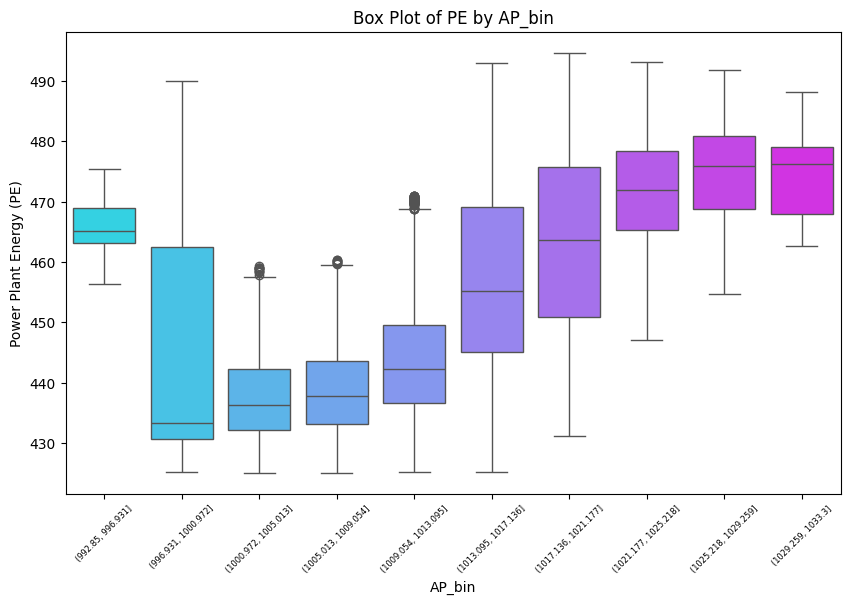

Outliers for RH_bin: Count = 11
Indices of outliers: [1175, 2924, 5483, 6470, 6780, 6795, 7949, 8052, 1262, 2371, 6882]



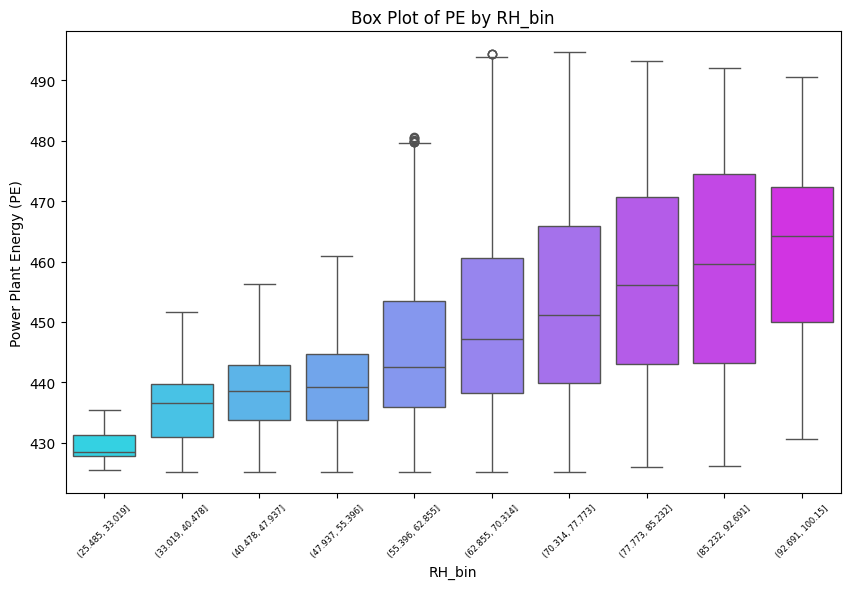

Outliers for AT_bin: Count = 0
Indices of outliers: []



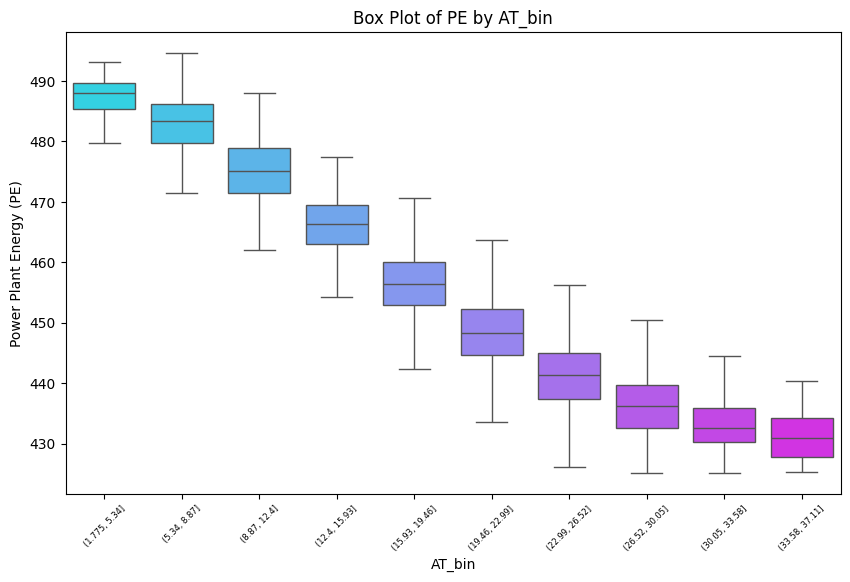

Outliers for V_bin: Count = 0
Indices of outliers: []



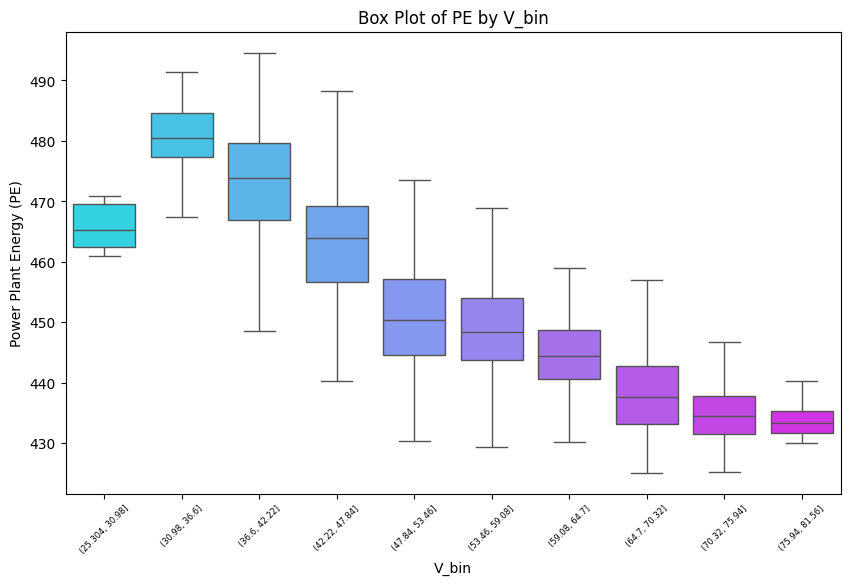

Remaining outliers after initial removal:

Remaining outliers for AP_bin: Count = 54
Indices of remaining outliers: [202, 476, 1156, 2510, 2875, 4036, 4658, 4679, 4713, 7595, 119, 177, 184, 349, 486, 530, 533, 726, 735, 1495, 2254, 2356, 2364, 2725, 3011, 3202, 3285, 3328, 4558, 5081, 5470, 5685, 5697, 5807, 5812, 5913, 5983, 6398, 6562, 6922, 6992, 7159, 7287, 7502, 7506, 7619, 7708, 7893, 8388, 8392, 8483, 8568, 8743, 8776]

Remaining outliers for RH_bin: Count = 8
Indices of remaining outliers: [2240, 2627, 3599, 4224, 7263, 7717, 8347, 7483]

Remaining outliers for AT_bin: Count = 0
Indices of remaining outliers: []

Remaining outliers for V_bin: Count = 0
Indices of remaining outliers: []

Final remaining outliers after second removal:

Final remaining outliers for AP_bin: Count = 29
Indices of final remaining outliers: [927, 1189, 2649, 3395, 3761, 3807, 6246, 6764, 8856, 255, 387, 2971, 3077, 3155, 3373, 5152, 5209, 5650, 6417, 6460, 6724, 7053, 7432, 8036, 8103, 9363, 9410, 948

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature
df_outliers_removed_final['AP_bin'] = pd.cut(df_outliers_removed_final['AP'], bins=10)
df_outliers_removed_final['RH_bin'] = pd.cut(df_outliers_removed_final['RH'], bins=10)
df_outliers_removed_final['AT_bin'] = pd.cut(df_outliers_removed_final['AT'], bins=10)
df_outliers_removed_final['V_bin'] = pd.cut(df_outliers_removed_final['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Function to count outliers
def count_outliers(df, feature, target):
    grouped = df.groupby(feature)[target]
    Q1 = grouped.quantile(0.25)
    Q3 = grouped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = []

    for name, group in grouped:
        lower = lower_bound[name]
        upper = upper_bound[name]
        # Identify outliers in the group
        outliers = group[(group < lower) | (group > upper)]
        outlier_indices.extend(outliers.index.tolist())
    
    return outlier_indices

# Count and print outliers for each feature
outliers_summary = {}

for feature in binned_features:
    outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    outliers_summary[feature] = outlier_indices
    print(f"Outliers for {feature}: Count = {len(outlier_indices)}")
    print(f"Indices of outliers: {outlier_indices}\n")

    # Create box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='PE', data=df_outliers_removed_final, palette='cool')
    plt.title(f'Box Plot of PE by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45, size=6)
    plt.show()

# Remove the identified outliers from df_outliers_removed_final
all_outlier_indices = set().union(*outliers_summary.values())
df_outliers_removed_final = df_outliers_removed_final.drop(index=all_outlier_indices)

# Re-check for remaining outliers in the updated DataFrame
print("Remaining outliers after initial removal:\n")
remaining_outliers_summary = {}

for feature in binned_features:
    remaining_outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    remaining_outliers_summary[feature] = remaining_outlier_indices
    print(f"Remaining outliers for {feature}: Count = {len(remaining_outlier_indices)}")
    print(f"Indices of remaining outliers: {remaining_outlier_indices}\n")

# Remove remaining outliers again from df_outliers_removed_final
final_outlier_indices = set().union(*remaining_outliers_summary.values())
df_outliers_removed_final = df_outliers_removed_final.drop(index=final_outlier_indices)

# Final check for any remaining outliers
print("Final remaining outliers after second removal:\n")
for feature in binned_features:
    final_remaining_outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    print(f"Final remaining outliers for {feature}: Count = {len(final_remaining_outlier_indices)}")
    print(f"Indices of final remaining outliers: {final_remaining_outlier_indices}\n")

Outliers for AP_bin: Count = 29
Indices of outliers: [927, 1189, 2649, 3395, 3761, 3807, 6246, 6764, 8856, 255, 387, 2971, 3077, 3155, 3373, 5152, 5209, 5650, 6417, 6460, 6724, 7053, 7432, 8036, 8103, 9363, 9410, 9485, 9543]



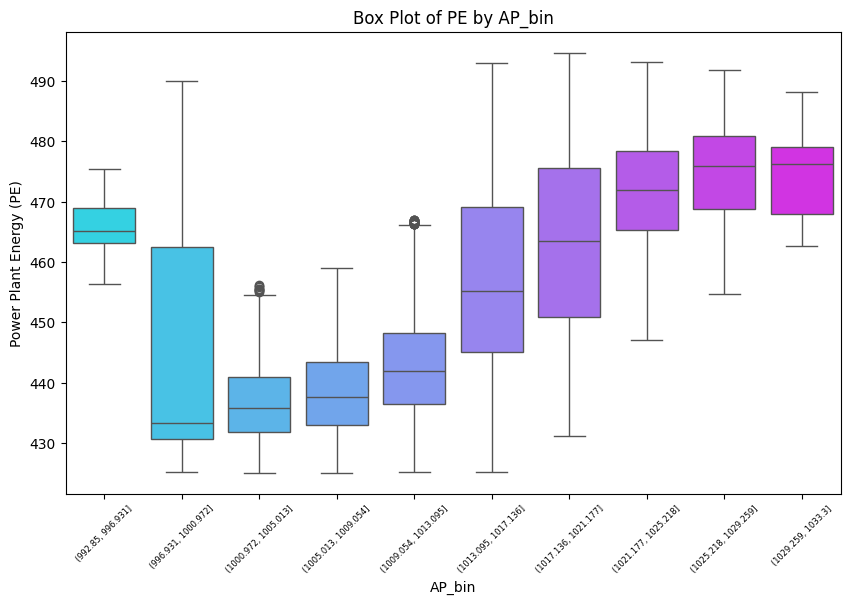

Outliers for RH_bin: Count = 5
Indices of outliers: [303, 1648, 8427, 8564, 8579]



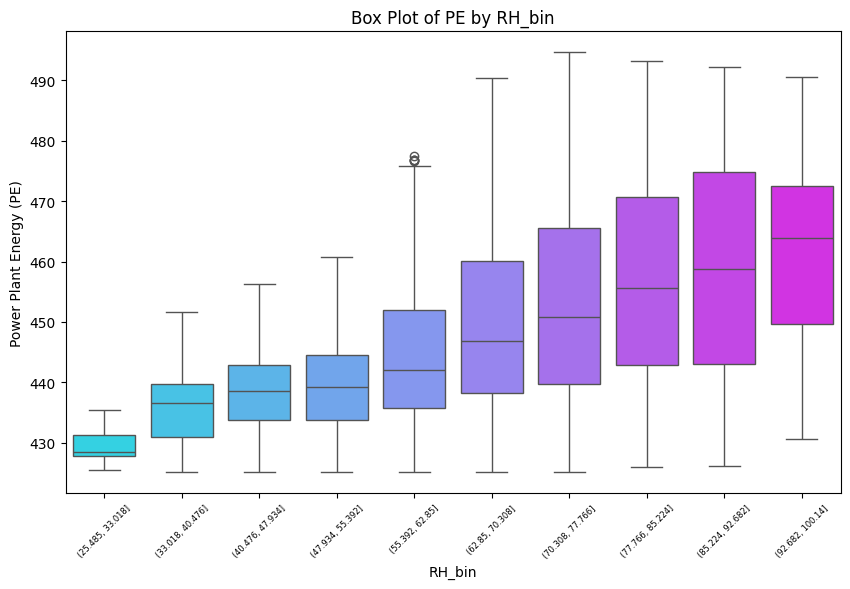

Outliers for AT_bin: Count = 2
Indices of outliers: [1562, 4783]



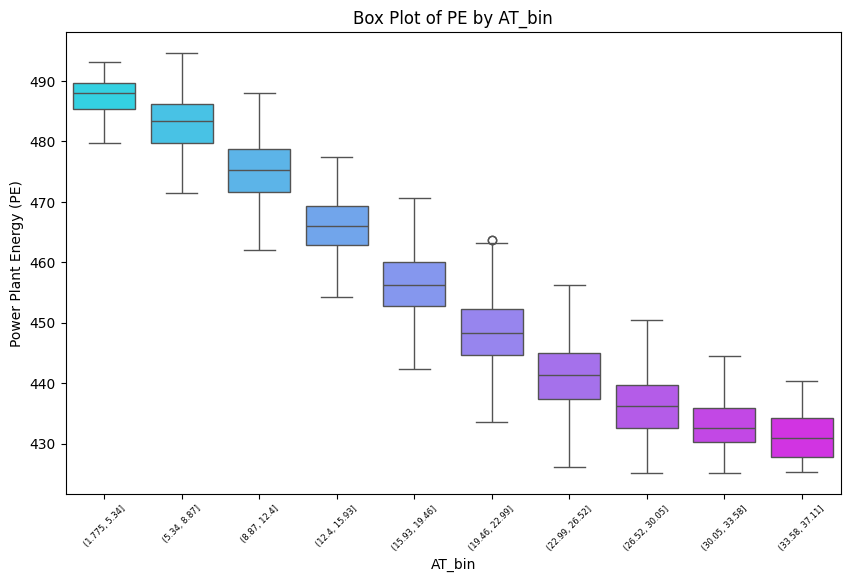

Outliers for V_bin: Count = 3
Indices of outliers: [6356, 3376, 5887]



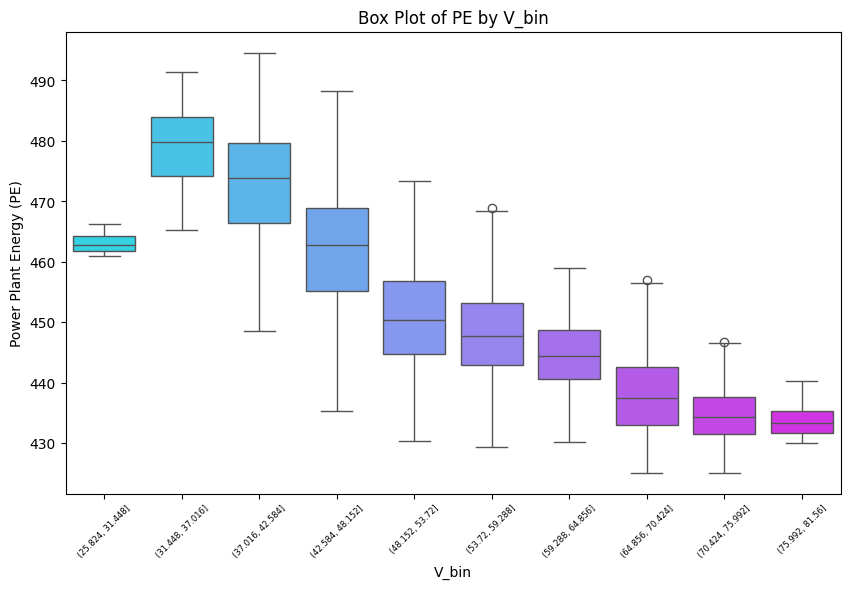

Outliers for AP_bin: Count = 11
Indices of outliers: [442, 7467, 666, 2183, 2340, 2823, 3383, 3500, 4500, 4527, 6622]



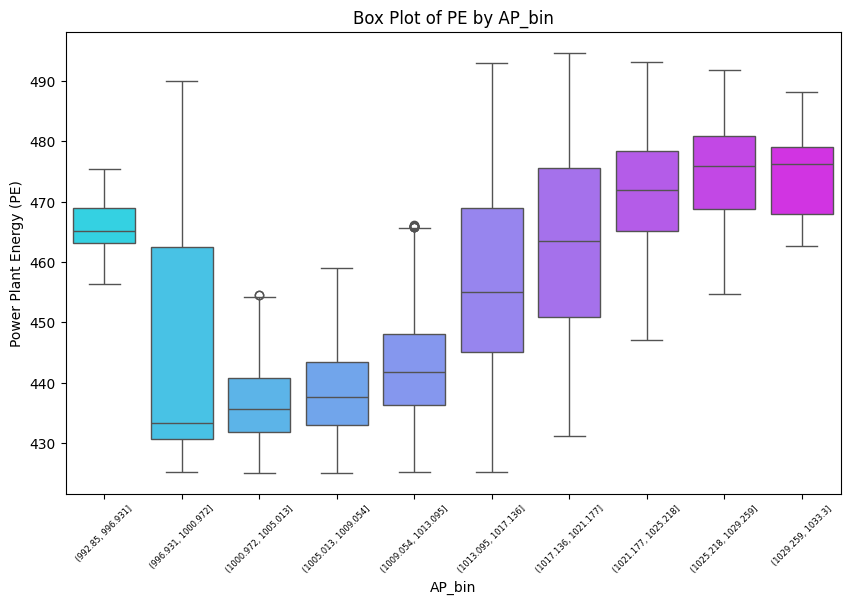

Outliers for RH_bin: Count = 22
Indices of outliers: [2955, 3893, 588, 1597, 2768, 4192, 4943, 5020, 5150, 5370, 6561, 6578, 7406, 7507, 7689, 7894, 8050, 8092, 8558, 8623, 9318, 9424]



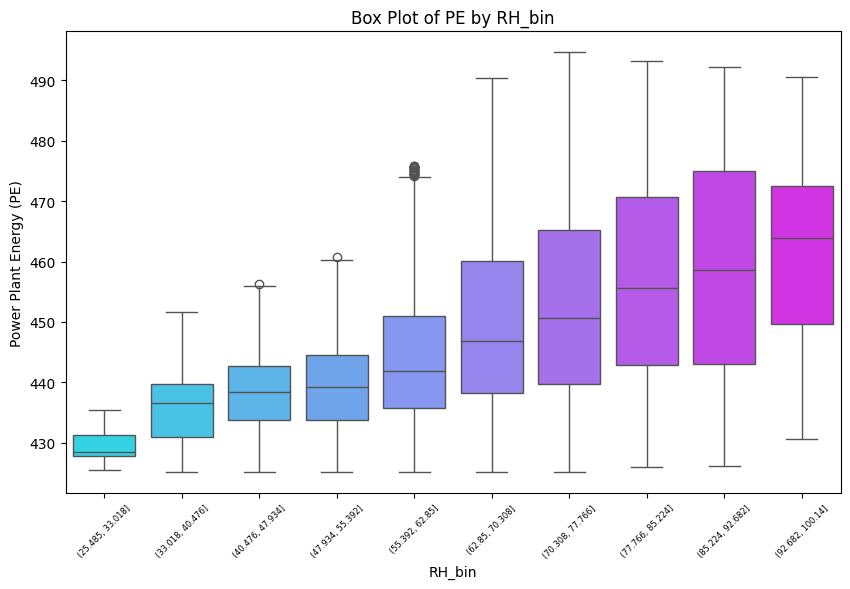

Outliers for AT_bin: Count = 1
Indices of outliers: [6625]



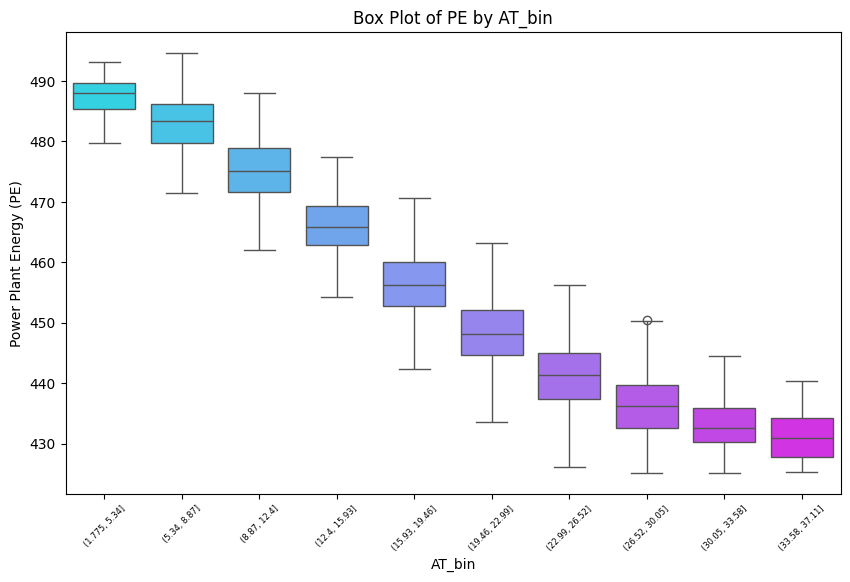

Outliers for V_bin: Count = 0
Indices of outliers: []



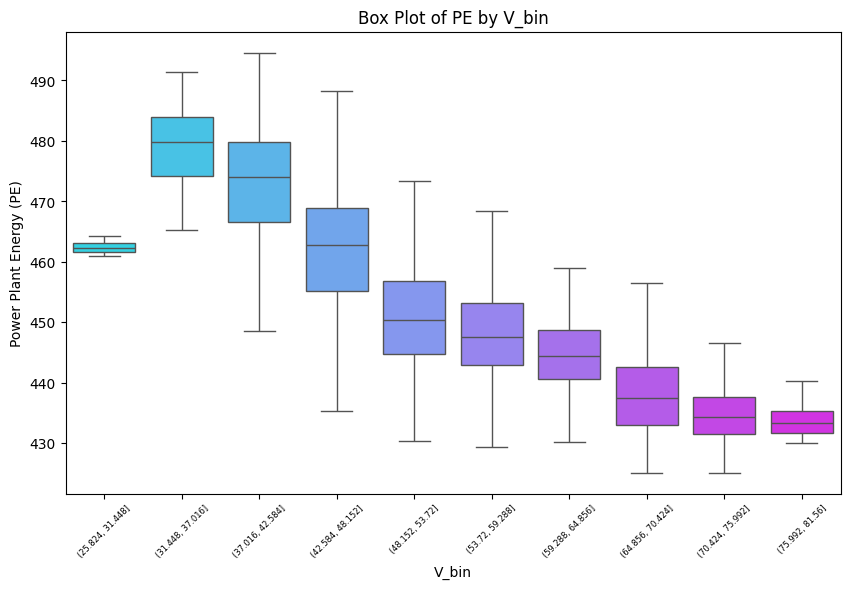

Outliers for AP_bin: Count = 12
Indices of outliers: [6577, 120, 899, 1099, 1972, 3085, 3190, 3603, 3947, 7840, 8359, 8607]



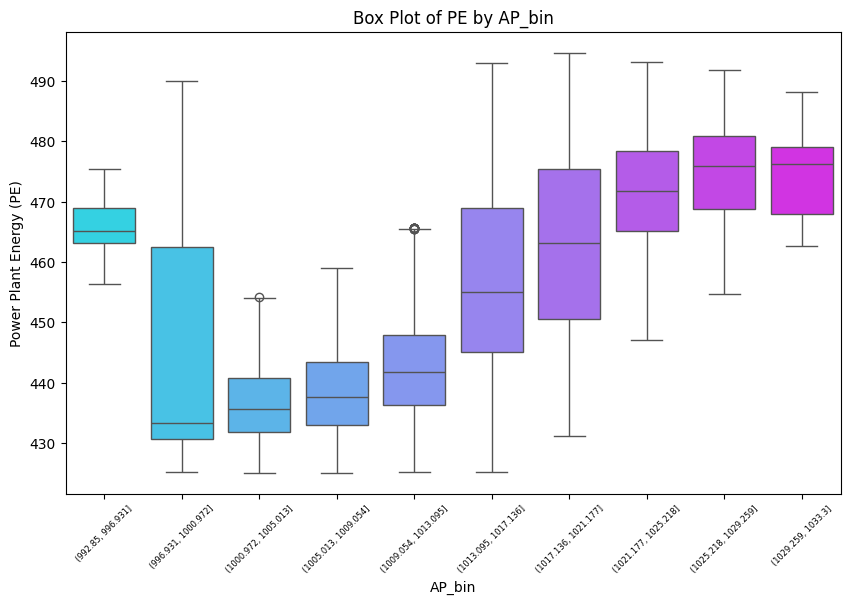

Outliers for RH_bin: Count = 11
Indices of outliers: [311, 2012, 2461, 3505, 3891, 3996, 4939, 5743, 6236, 6374, 9196]



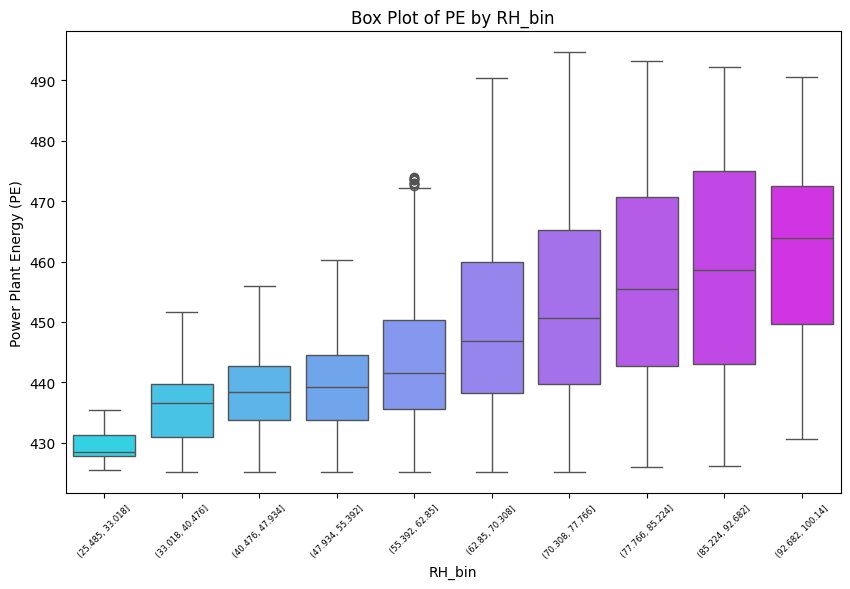

Outliers for AT_bin: Count = 0
Indices of outliers: []



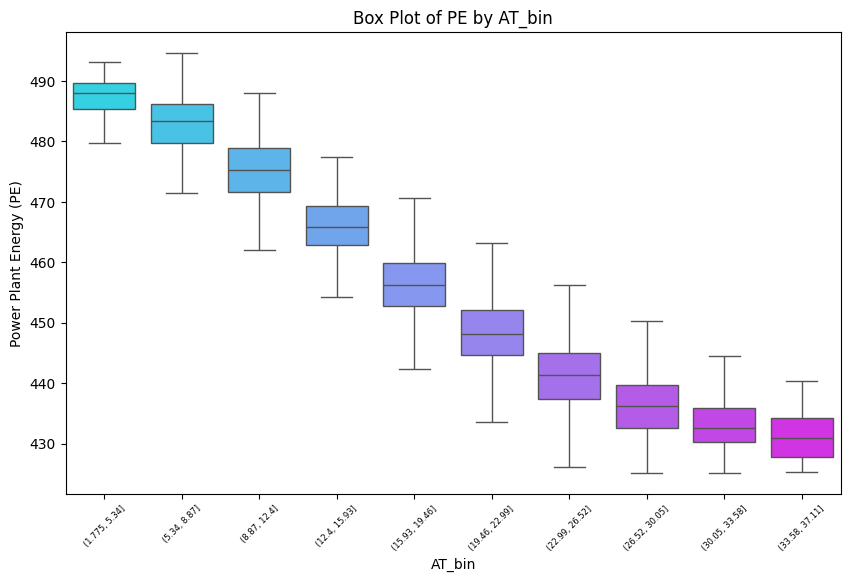

Outliers for V_bin: Count = 0
Indices of outliers: []



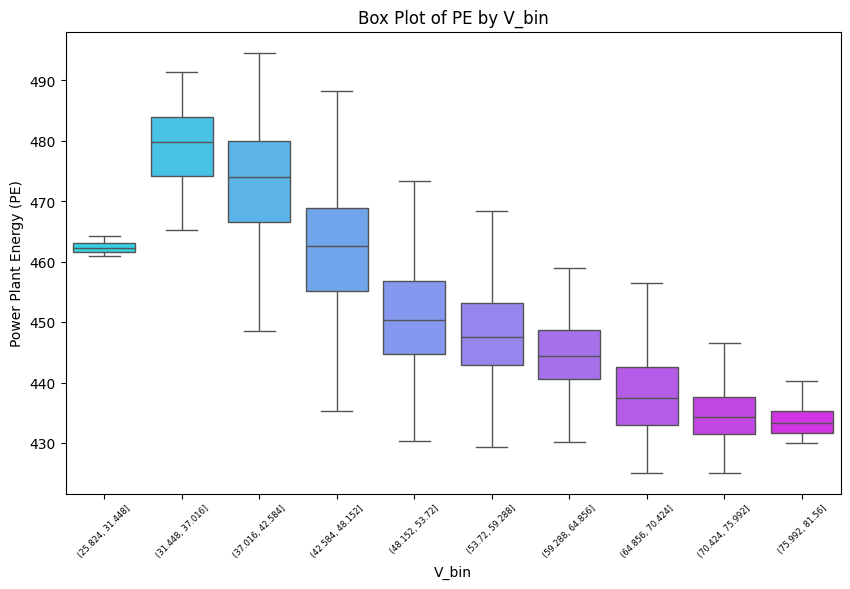

Outliers for AP_bin: Count = 5
Indices of outliers: [553, 3305, 3932, 7631, 9263]



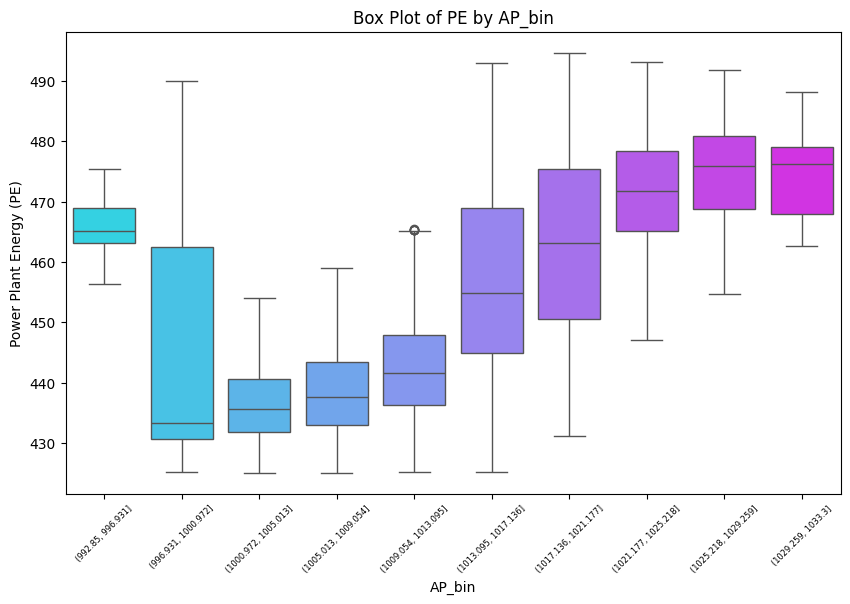

Outliers for RH_bin: Count = 7
Indices of outliers: [182, 2039, 2420, 2846, 7105, 8977, 9378]



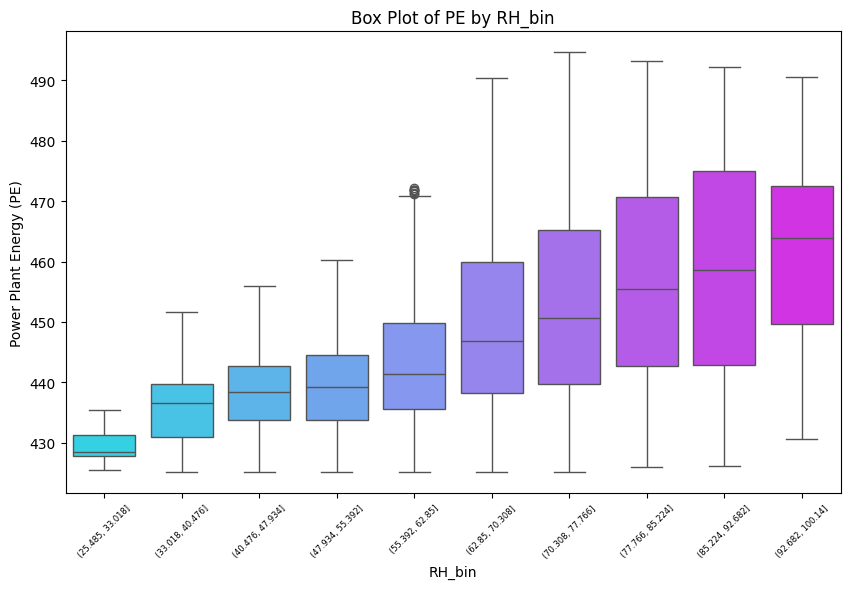

Outliers for AT_bin: Count = 0
Indices of outliers: []



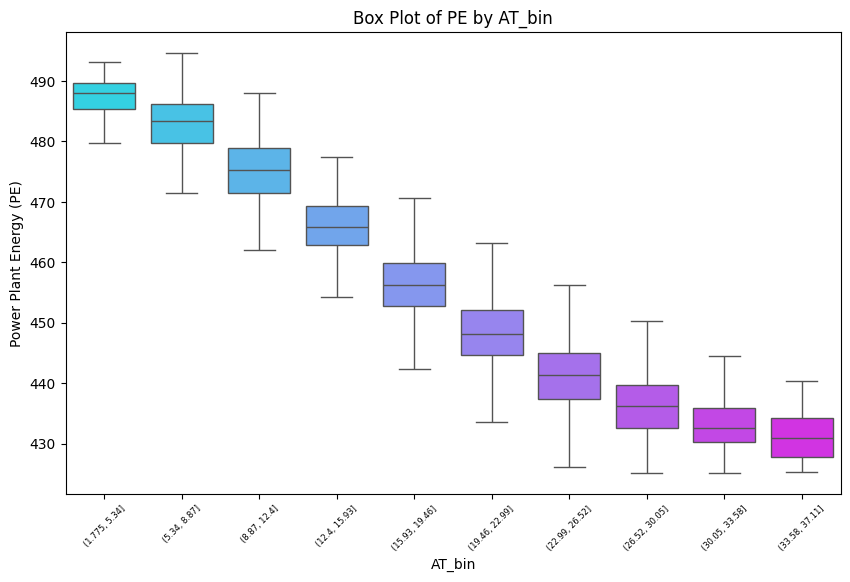

Outliers for V_bin: Count = 0
Indices of outliers: []



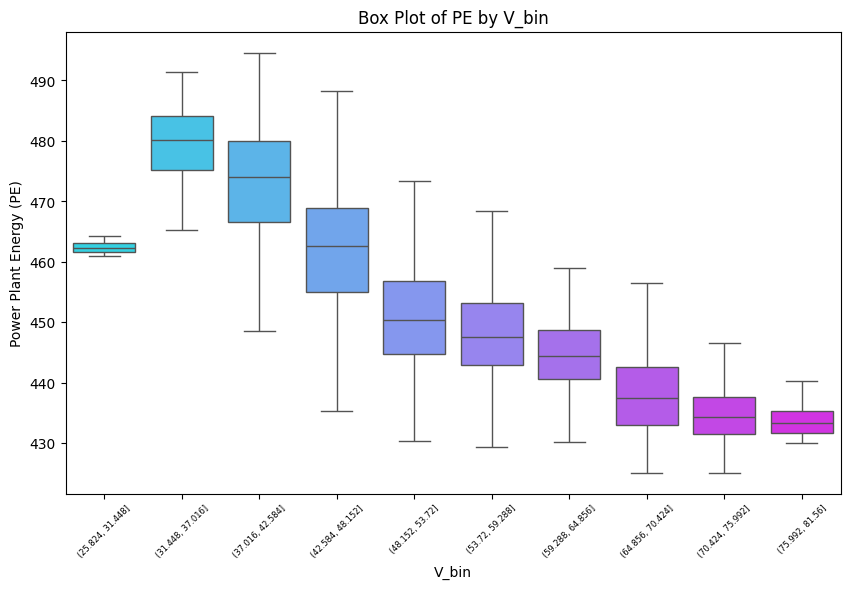

Outliers for AP_bin: Count = 2
Indices of outliers: [2615, 2704]



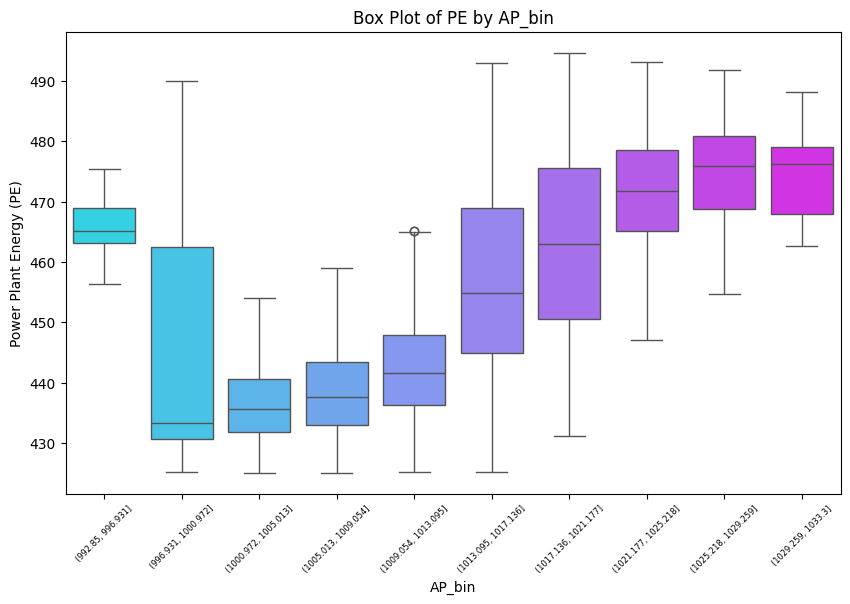

Outliers for RH_bin: Count = 2
Indices of outliers: [5985, 9550]



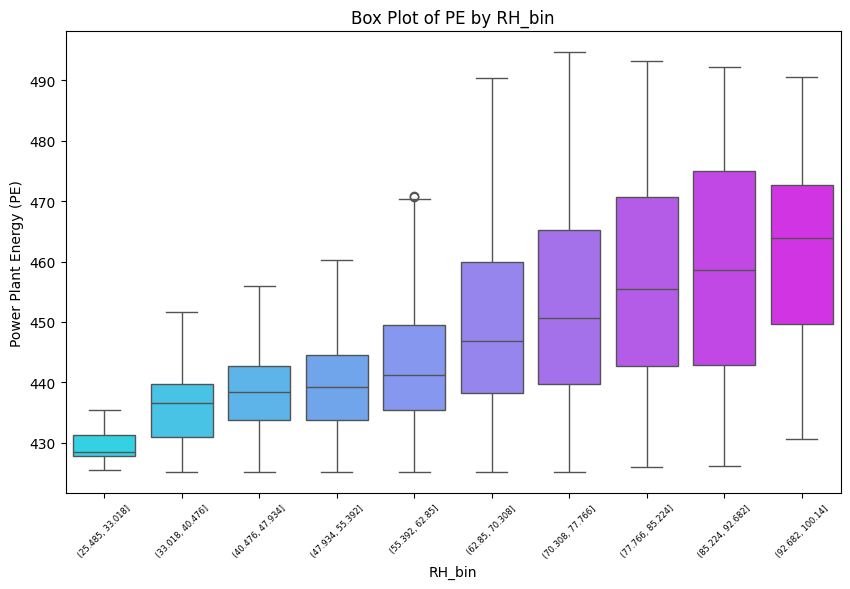

Outliers for AT_bin: Count = 0
Indices of outliers: []



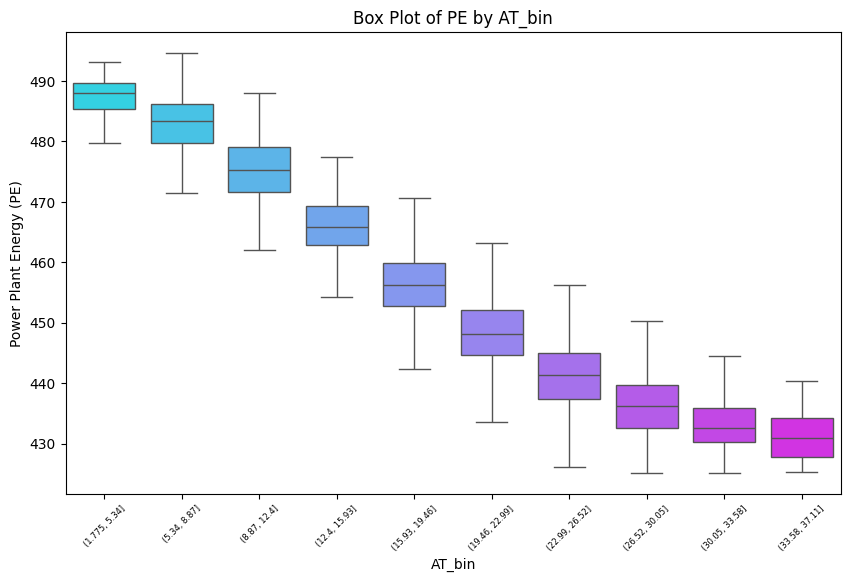

Outliers for V_bin: Count = 0
Indices of outliers: []



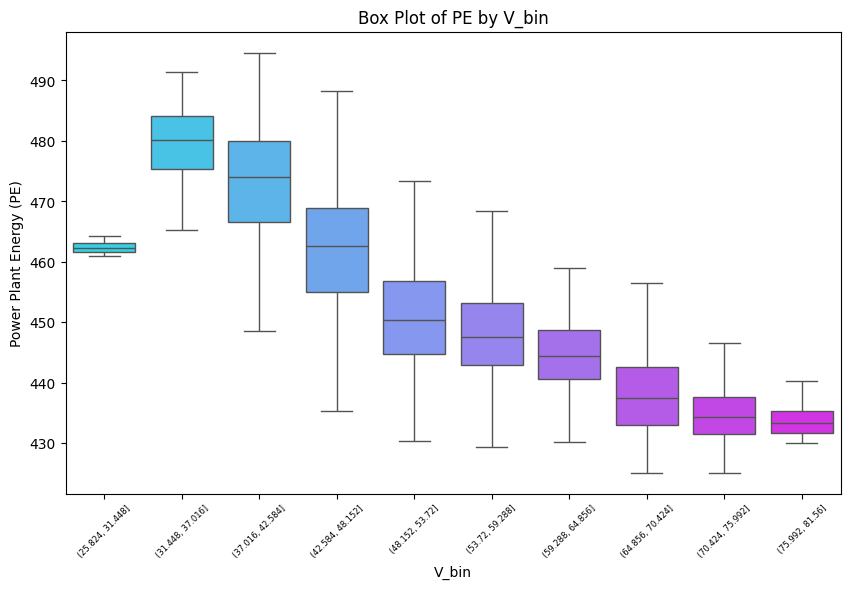

Outliers for AP_bin: Count = 0
Indices of outliers: []



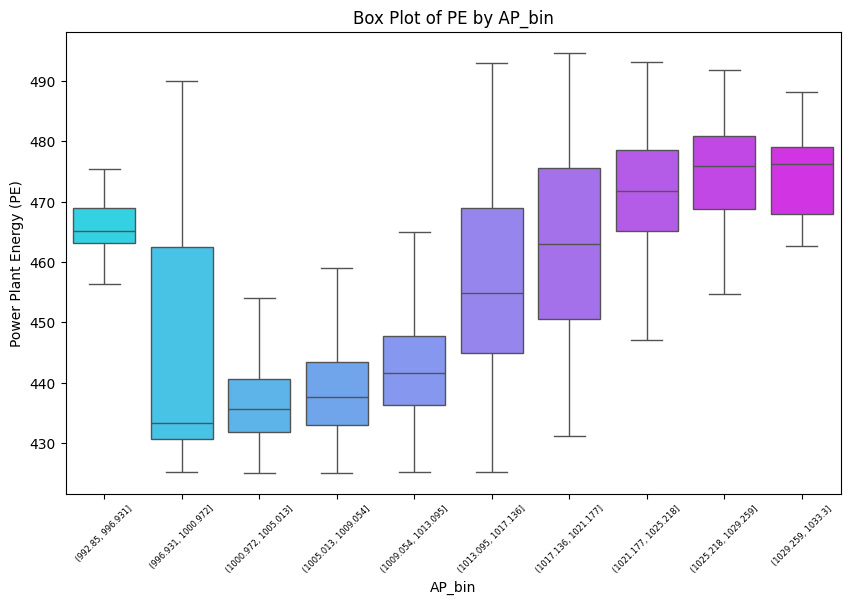

Outliers for RH_bin: Count = 4
Indices of outliers: [1715, 2243, 3215, 7395]



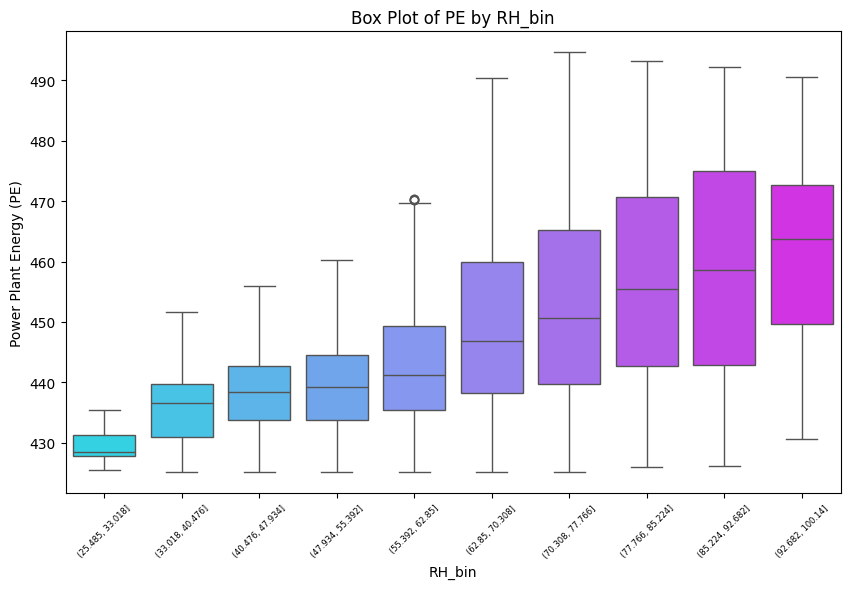

Outliers for AT_bin: Count = 0
Indices of outliers: []



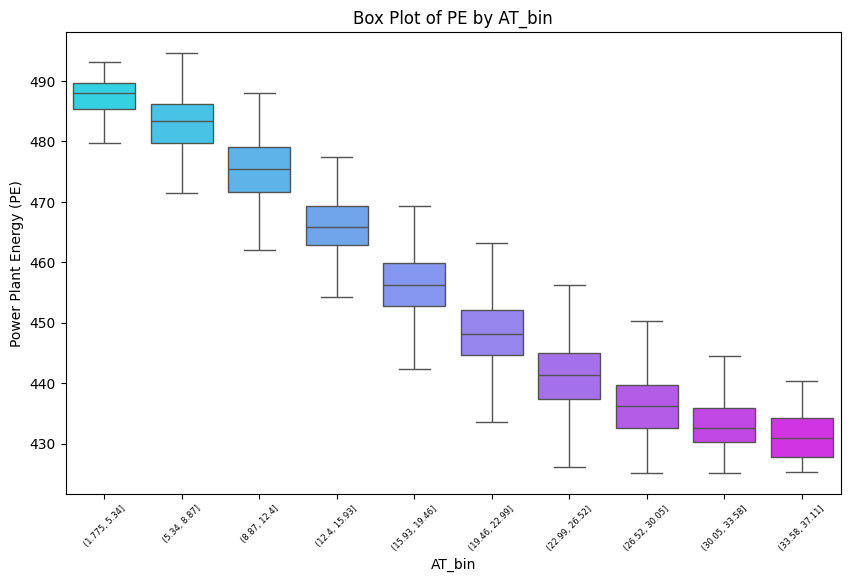

Outliers for V_bin: Count = 0
Indices of outliers: []



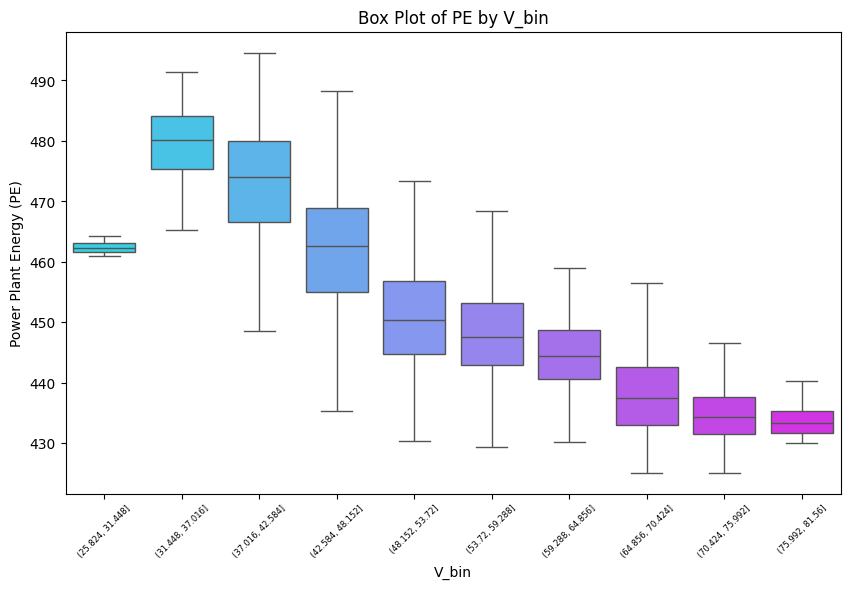

Outliers for AP_bin: Count = 0
Indices of outliers: []



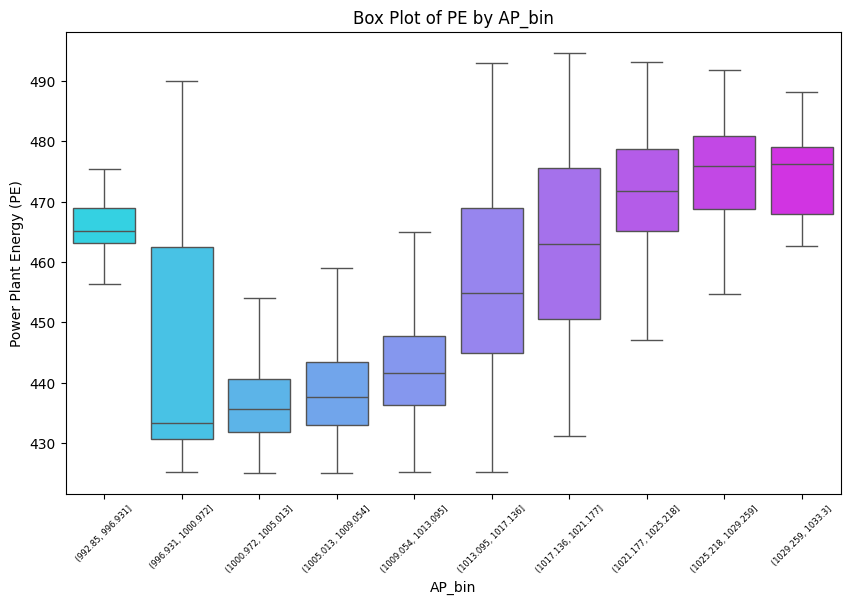

Outliers for RH_bin: Count = 0
Indices of outliers: []



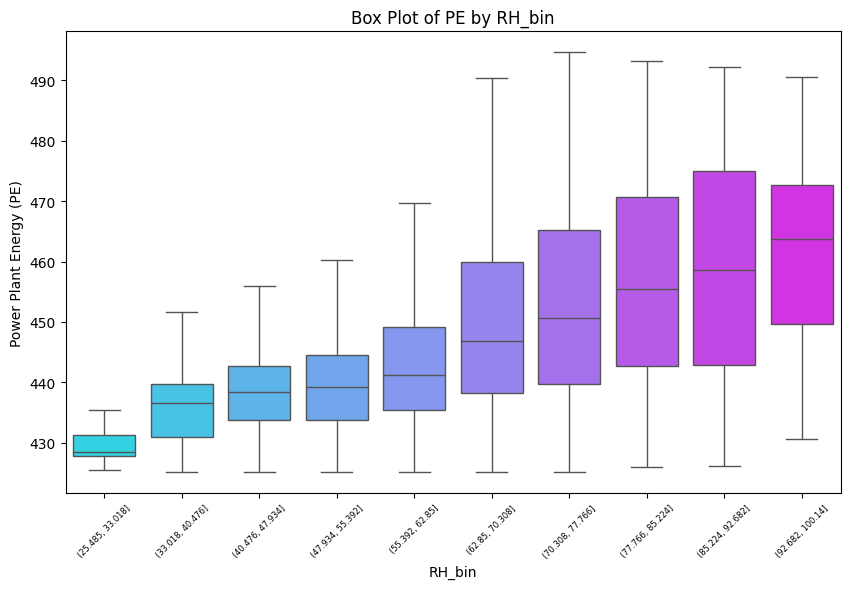

Outliers for AT_bin: Count = 0
Indices of outliers: []



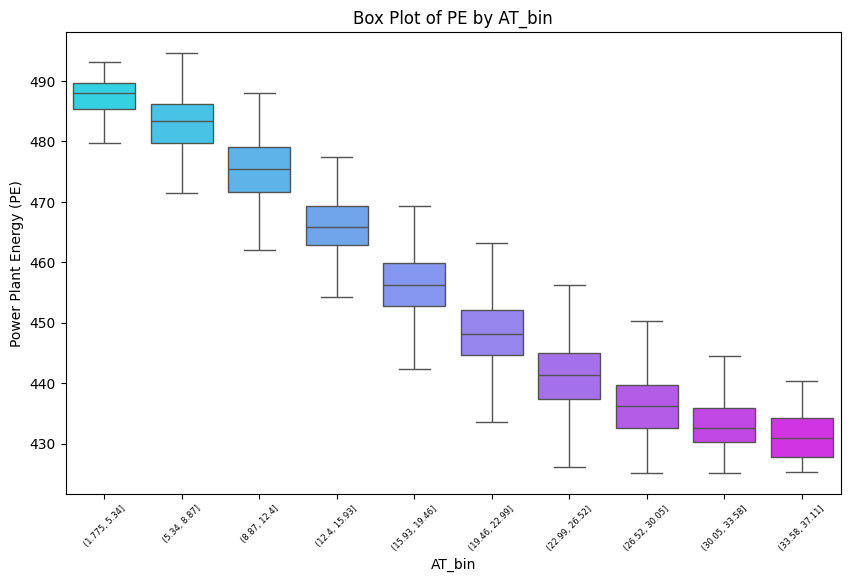

Outliers for V_bin: Count = 0
Indices of outliers: []



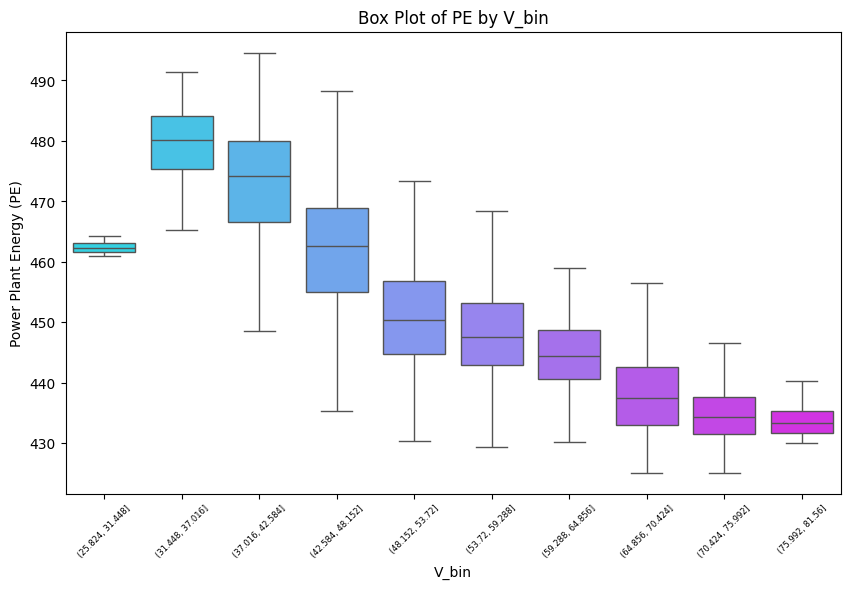

Final remaining outliers after all removals:

Final remaining outliers for AP_bin: Count = 0
Indices of final remaining outliers: []

Final remaining outliers for RH_bin: Count = 0
Indices of final remaining outliers: []

Final remaining outliers for AT_bin: Count = 0
Indices of final remaining outliers: []

Final remaining outliers for V_bin: Count = 0
Indices of final remaining outliers: []



In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature
df_outliers_removed_final['AP_bin'] = pd.cut(df_outliers_removed_final['AP'], bins=10)
df_outliers_removed_final['RH_bin'] = pd.cut(df_outliers_removed_final['RH'], bins=10)
df_outliers_removed_final['AT_bin'] = pd.cut(df_outliers_removed_final['AT'], bins=10)
df_outliers_removed_final['V_bin'] = pd.cut(df_outliers_removed_final['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Function to count outliers
def count_outliers(df, feature, target):
    grouped = df.groupby(feature)[target]
    Q1 = grouped.quantile(0.25)
    Q3 = grouped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = []

    for name, group in grouped:
        lower = lower_bound[name]
        upper = upper_bound[name]
        # Identify outliers in the group
        outliers = group[(group < lower) | (group > upper)]
        outlier_indices.extend(outliers.index.tolist())
    
    return outlier_indices

# Initial removal of outliers
while True:
    outliers_summary = {}
    has_outliers = False

    for feature in binned_features:
        outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
        outliers_summary[feature] = outlier_indices

        # Count and print outliers for the feature
        print(f"Outliers for {feature}: Count = {len(outlier_indices)}")
        print(f"Indices of outliers: {outlier_indices}\n")

        # Create box plot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=feature, y='PE', data=df_outliers_removed_final, palette='cool')
        plt.title(f'Box Plot of PE by {feature}')
        plt.xlabel(feature)
        plt.ylabel('Power Plant Energy (PE)')
        plt.xticks(rotation=45, size=6)
        plt.show()

        # Check if there are outliers to remove
        if len(outlier_indices) > 0:
            has_outliers = True

    # If no outliers are found, break the loop
    if not has_outliers:
        break

    # Remove identified outliers from df_outliers_removed_final
    all_outlier_indices = set().union(*outliers_summary.values())
    df_outliers_removed_final = df_outliers_removed_final.drop(index=all_outlier_indices)

# Final check for remaining outliers
print("Final remaining outliers after all removals:\n")
for feature in binned_features:
    final_remaining_outlier_indices = count_outliers(df_outliers_removed_final, feature, 'PE')
    print(f"Final remaining outliers for {feature}: Count = {len(final_remaining_outlier_indices)}")
    print(f"Indices of final remaining outliers: {final_remaining_outlier_indices}\n")

# while loop to remove outliers from binned plot of PE

Outliers for AP_bin: Count = 149
Indices of outliers: [7486, 85, 1174, 1678, 1770, 2546, 2603, 2863, 3974, 4628, 4912, 5646, 5770, 5883, 5912, 7081, 7484, 7692, 8001, 8514, 8630, 8967, 9452, 13, 56, 148, 188, 239, 285, 425, 492, 542, 580, 652, 805, 939, 941, 988, 1065, 1129, 1145, 1172, 1402, 1569, 1614, 1686, 1728, 1905, 1929, 2114, 2294, 2307, 2312, 2483, 2645, 2665, 2743, 2794, 2918, 2973, 3156, 3353, 3591, 3698, 3798, 3861, 4041, 4205, 4454, 4507, 4673, 4924, 4983, 5032, 5303, 5560, 5571, 5847, 5904, 5992, 6016, 6069, 6140, 6323, 6331, 6520, 6954, 7010, 7048, 7211, 7542, 7948, 7997, 8019, 8181, 8267, 8606, 9005, 9022, 9217, 140, 212, 336, 347, 396, 437, 758, 1159, 1280, 1362, 1440, 1555, 1663, 1695, 2010, 2059, 2135, 2172, 2311, 2351, 3017, 3134, 3476, 3690, 4245, 5190, 5336, 5499, 5500, 5534, 5614, 5748, 5963, 6618, 6721, 6923, 7178, 7197, 7347, 7651, 8072, 9121, 9236, 9430, 9447, 9459, 9472, 1883, 3539]

Outliers for RH_bin: Count = 83
Indices of outliers: [3909, 4445, 6302, 6501

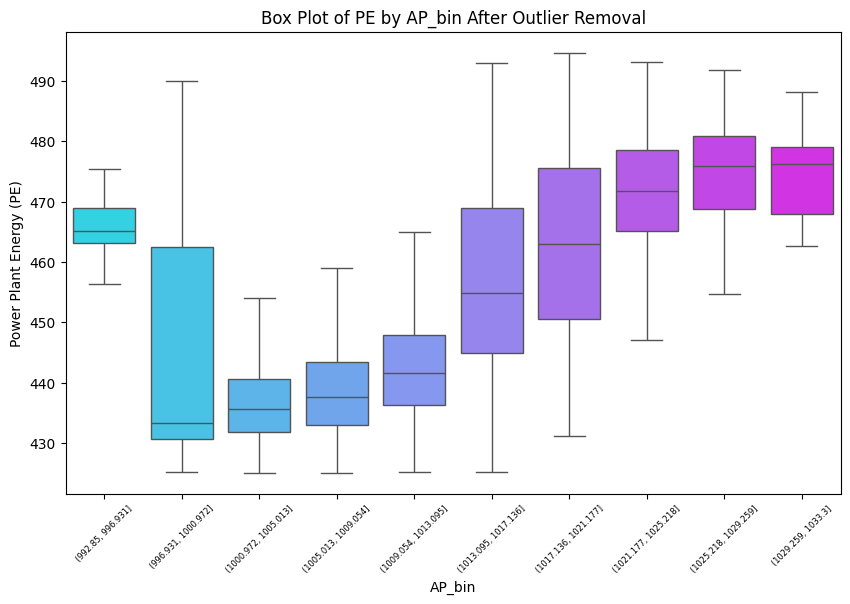

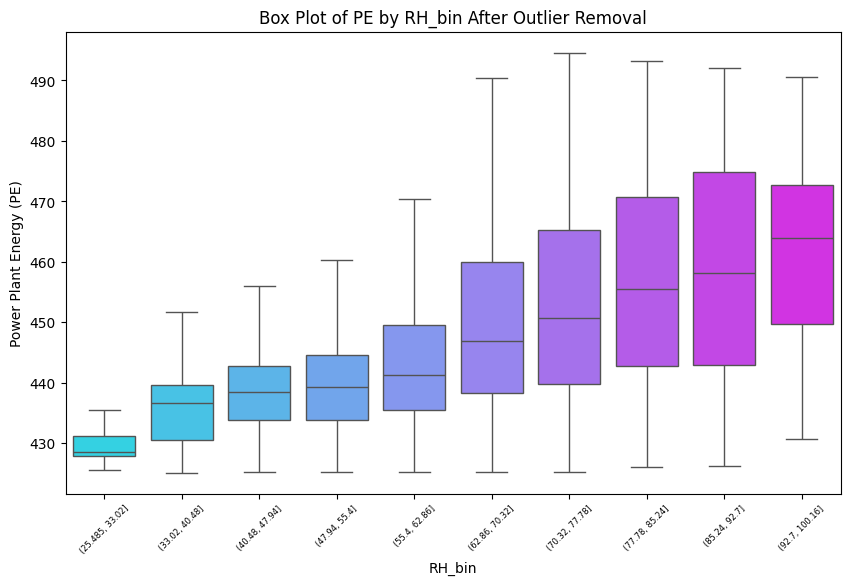

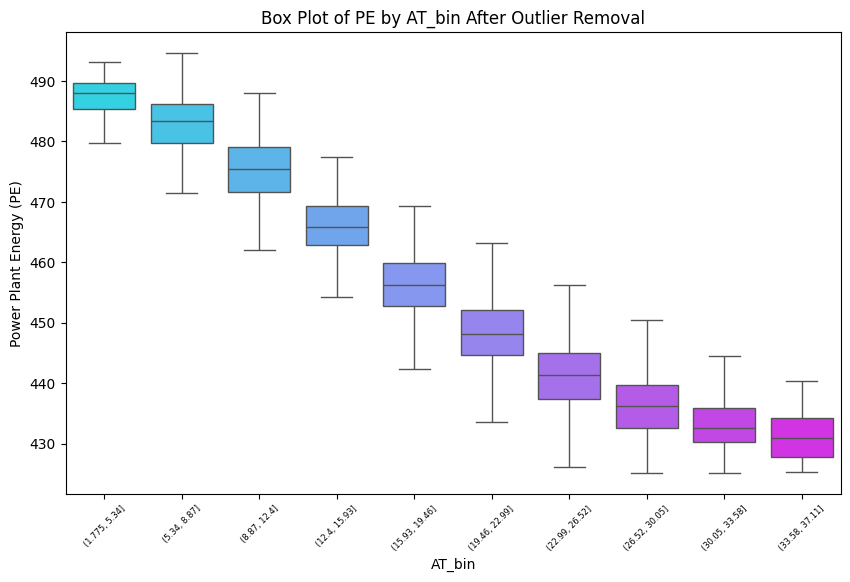

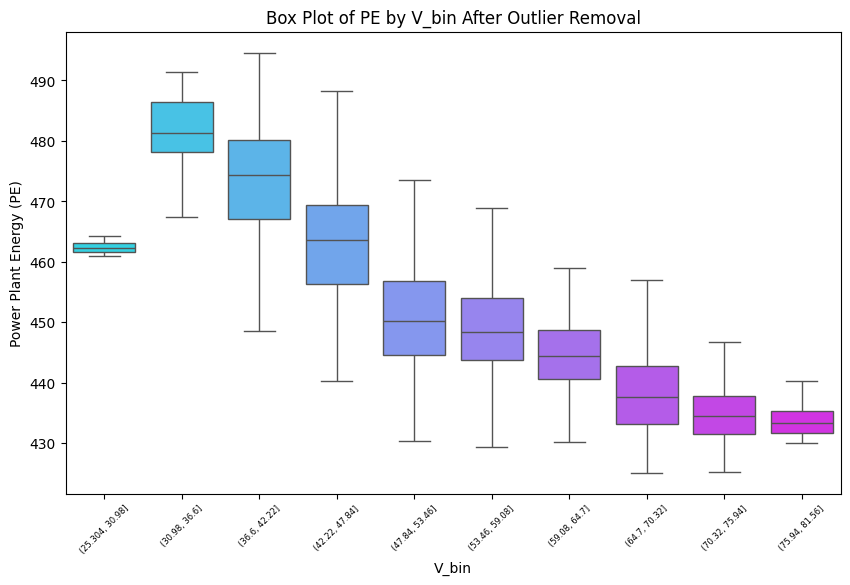

In [31]:
# while loops to remove outliers from binned plot of PE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature in 'df'
df['AP_bin'] = pd.cut(df['AP'], bins=10)
df['RH_bin'] = pd.cut(df['RH'], bins=10)
df['AT_bin'] = pd.cut(df['AT'], bins=10)
df['V_bin'] = pd.cut(df['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Function to count outliers
def count_outliers(df, feature, target):
    grouped = df.groupby(feature)[target]
    Q1 = grouped.quantile(0.25)
    Q3 = grouped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = []

    for name, group in grouped:
        lower = lower_bound[name]
        upper = upper_bound[name]
        # Identify outliers in the group
        outliers = group[(group < lower) | (group > upper)]
        outlier_indices.extend(outliers.index.tolist())
    
    return outlier_indices

# Create a copy of the original DataFrame to remove outliers from
df_outliers_removed = df.copy()

# Initial removal of outliers
while True:
    outliers_summary = {}
    has_outliers = False

    for feature in binned_features:
        outlier_indices = count_outliers(df_outliers_removed, feature, 'PE')
        outliers_summary[feature] = outlier_indices

        # Count and print outliers for the feature
        print(f"Outliers for {feature}: Count = {len(outlier_indices)}")
        print(f"Indices of outliers: {outlier_indices}\n")

        # Check if there are outliers to remove
        if len(outlier_indices) > 0:
            has_outliers = True

    # If no outliers are found, break the loop
    if not has_outliers:
        break

    # Remove identified outliers from df_outliers_removed
    all_outlier_indices = set().union(*outliers_summary.values())
    df_outliers_removed = df_outliers_removed.drop(index=all_outlier_indices)

# Final check for remaining outliers
print("Final remaining outliers after all removals:\n")
for feature in binned_features:
    final_remaining_outlier_indices = count_outliers(df_outliers_removed, feature, 'PE')
    print(f"Final remaining outliers for {feature}: Count = {len(final_remaining_outlier_indices)}")
    print(f"Indices of final remaining outliers: {final_remaining_outlier_indices}\n")

# Now create and show box plots after outlier removal
for feature in binned_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='PE', data=df_outliers_removed, palette='cool')
    plt.title(f'Box Plot of PE by {feature} After Outlier Removal')
    plt.xlabel(feature)
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45, size=6)
    plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature in 'df'
df['AP_bin'] = pd.cut(df['AP'], bins=10)
df['RH_bin'] = pd.cut(df['RH'], bins=10)
df['AT_bin'] = pd.cut(df['AT'], bins=10)
df['V_bin'] = pd.cut(df['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Function to count outliers
def count_outliers(df, feature, target):
    grouped = df.groupby(feature)[target]
    Q1 = grouped.quantile(0.25)
    Q3 = grouped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = []

    for name, group in grouped:
        lower = lower_bound[name]
        upper = upper_bound[name]
        # Identify outliers in the group
        outliers = group[(group < lower) | (group > upper)]
        outlier_indices.extend(outliers.index.tolist())
    
    return outlier_indices

# Create a copy of the original DataFrame to remove outliers from
df_outliers_removed = df.copy()

# Initial removal of outliers
while True:
    outliers_summary = {}
    has_outliers = False

    for feature in binned_features:
        outlier_indices = count_outliers(df_outliers_removed, feature, 'PE')
        outliers_summary[feature] = outlier_indices

        # Count and print outliers for the feature
        print(f"Outliers for {feature}: Count = {len(outlier_indices)}")
        print(f"Indices of outliers: {outlier_indices}\n")

        # Check if there are outliers to remove
        if len(outlier_indices) > 0:
            has_outliers = True

    # If no outliers are found, break the loop
    if not has_outliers:
        break

    # Remove identified outliers from df_outliers_removed
    all_outlier_indices = set().union(*outliers_summary.values())
    df_outliers_removed = df_outliers_removed.drop(index=all_outlier_indices)

# Final check for remaining outliers
print("Final remaining outliers after all removals:\n")
for feature in binned_features:
    final_remaining_outlier_indices = count_outliers(df_outliers_removed, feature, 'PE')
    print(f"Final remaining outliers for {feature}: Count = {len(final_remaining_outlier_indices)}")
    print(f"Indices of final remaining outliers: {final_remaining_outlier_indices}\n")

# Now create and show box plots after outlier removal
for feature in binned_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='PE', data=df_outliers_removed, palette='cool')
    plt.title(f'Box Plot of PE by {feature} After Outlier Removal')
    plt.xlabel(feature)
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45, size=6)
    plt.show()



## Remove PE outliers then replot, then retrain

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Features and target variable from df and df_no_outliers
X_full = df[['AT']]  # Using 'AT' from the original dataframe
X_no_outliers = df_no_outliers[['AT']]  # Using 'AT' from the outlier-removed dataframe
y_full = df['PE']
y_no_outliers = df_no_outliers['PE']

# Initialize the linear regression model
model_full = LinearRegression()
model_no_outliers = LinearRegression()

# Fit the model on the original data (with outliers)
model_full.fit(X_full, y_full)

# Fit the model on the data without outliers
model_no_outliers.fit(X_no_outliers, y_no_outliers)

# Predict on the training data
y_pred_full = model_full.predict(X_full)
y_pred_no_outliers = model_no_outliers.predict(X_no_outliers)

# Calculate performance metrics
mse_full = mean_squared_error(y_full, y_pred_full)
r2_full = r2_score(y_full, y_pred_full)

mse_no_outliers = mean_squared_error(y_no_outliers, y_pred_no_outliers)
r2_no_outliers = r2_score(y_no_outliers, y_pred_no_outliers)

# Output the comparison
print("Model trained with full data (with outliers):")
print(f"R-squared: {r2_full:.4f}")
print(f"Mean Squared Error: {mse_full:.4f}")

print("\nModel trained with data without outliers:")
print(f"R-squared: {r2_no_outliers:.4f}")
print(f"Mean Squared Error: {mse_no_outliers:.4f}")

Model trained with full data (with outliers):
R-squared: 0.8989
Mean Squared Error: 29.4317

Model trained with data without outliers:
R-squared: 0.9113
Mean Squared Error: 23.5822


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Features and target variable from df and df_outliers_removed
X_full = df[['AT', 'AP', 'V', 'RH']]  # Using multiple predictors from the original dataframe
X_no_outliers = df_no_outliers[['AT', 'AP','V', 'RH']]  # Using the same predictors from the outlier-removed dataframe
y_full = df['PE']
y_no_outliers = df_no_outliers['PE']

# Initialize the linear regression model
model_full = LinearRegression()
model_no_outliers = LinearRegression()

# Fit the model on the original data (with outliers)
model_full.fit(X_full, y_full)

# Fit the model on the data without outliers
model_no_outliers.fit(X_no_outliers, y_no_outliers)

# Predict on the training data
y_pred_full = model_full.predict(X_full)
y_pred_no_outliers = model_no_outliers.predict(X_no_outliers)

# Calculate performance metrics
mse_full = mean_squared_error(y_full, y_pred_full)
r2_full = r2_score(y_full, y_pred_full)

mse_no_outliers = mean_squared_error(y_no_outliers, y_pred_no_outliers)
r2_no_outliers = r2_score(y_no_outliers, y_pred_no_outliers)

# Output the comparison
print("Model trained with full data (with outliers):")
print(f"R-squared: {r2_full:.4f}")
print(f"Mean Squared Error: {mse_full:.4f}")

print("\nModel trained with data without outliers:")
print(f"R-squared: {r2_no_outliers:.4f}")
print(f"Mean Squared Error: {mse_no_outliers:.4f}")

Model trained with full data (with outliers):
R-squared: 0.9287
Mean Squared Error: 20.7674

Model trained with data without outliers:
R-squared: 0.9375
Mean Squared Error: 16.6076


# The ANOVA table
### will show the F-statistic and p-values for each main effect and interaction, allowing you to assess the significance of each factor and their combinations in predicting 'PE'.

F-statistic: is calculated by taking the ratio of the variance between the feature variables, to the variance within the groups.

P-value less than 0.05 suggests that there is strong evidence against the null hypothesis, indicating that at least one group mean is significantly different from the others.

(low p and high F = good)

#### The F-statistic in ANOVA tests the null hypothesis that all group means are equal.
#### The F-statistic is a ratio of the variance between group means to the variance within the groups, used to test whether there are significant differences between multiple groups.

posx and posy should be finite values
posx and posy should be finite values


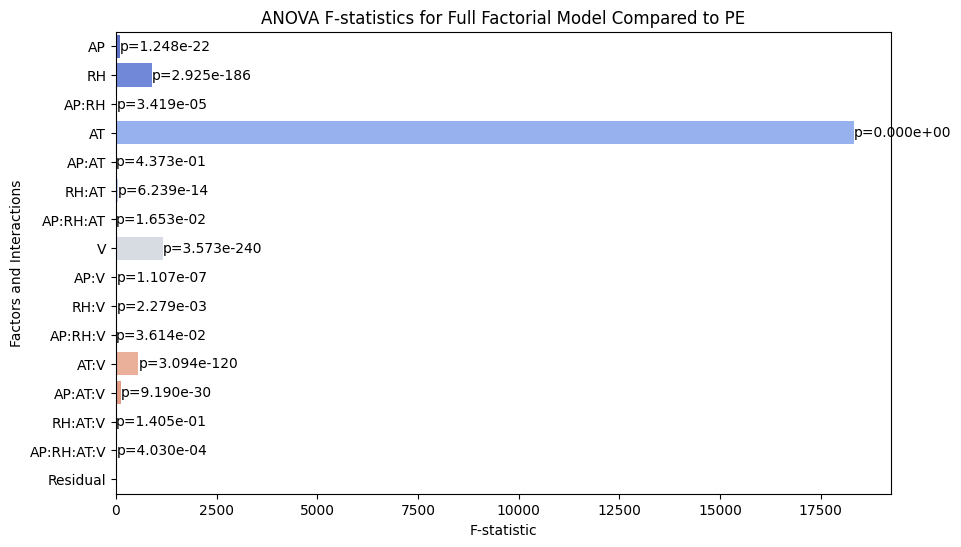

In [23]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains columns AP, RH, AT, V, and PE

# Fit the full factorial model
formula = 'PE ~ AP * RH * AT * V'
model = ols(formula, data=df).fit() #examines how the effect of one variable on PE might depend on the values of the others.

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Extract the F-statistic values and p-values
anova_results = anova_table[['F', 'PR(>F)']].reset_index()
anova_results.columns = ['Factor', 'F_statistic', 'p_value']

# Plot F-statistics with bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='F_statistic', y='Factor', data=anova_results, palette='coolwarm')

# Annotate each bar with its corresponding p-value
for i, row in anova_results.iterrows():
    plt.text(row.F_statistic + 0.1, i, f'p={row.p_value:.3e}', color='black', va='center')

# Add title and labels
plt.title("ANOVA F-statistics for Full Factorial Model Compared to PE")
plt.xlabel("F-statistic")
plt.ylabel("Factors and Interactions")
plt.show()

## The high F-statistic for AT suggests it explains much of the variance in the target variable (PE).
## However, other variables may still offer valuable explanatory power when considered together in the model, even if their individual F-statistics are lower.

F-statistic tells you the ratio of explained to unexplained variance.

Small F (near 1): Little evidence of difference between group means. This might indicate the factor or interaction has little impact on the target variable (in your case, PE).

Moderate F: Some difference between group means, but not extremely strong.

Large F: Strong evidence that group means differ, suggesting the factor/interaction significantly affects the target variable.

p-value shows the statistical significance of that result.

Low p-value (< 0.05): Indicates that the factor or interaction likely has a significant effect on the target variable (PE). You reject the null hypothesis, suggesting that the effect is real.

High p-value (> 0.05): Suggests that the factor or interaction does not have a statistically significant effect, and you fail to reject the null hypothesis.

## Anova Log10
#### Good Model: A log10 F-statistic significantly greater than 0 
#### Bad Model: Values close to or less than 0 

In [24]:
import warnings
warnings.filterwarnings("ignore")

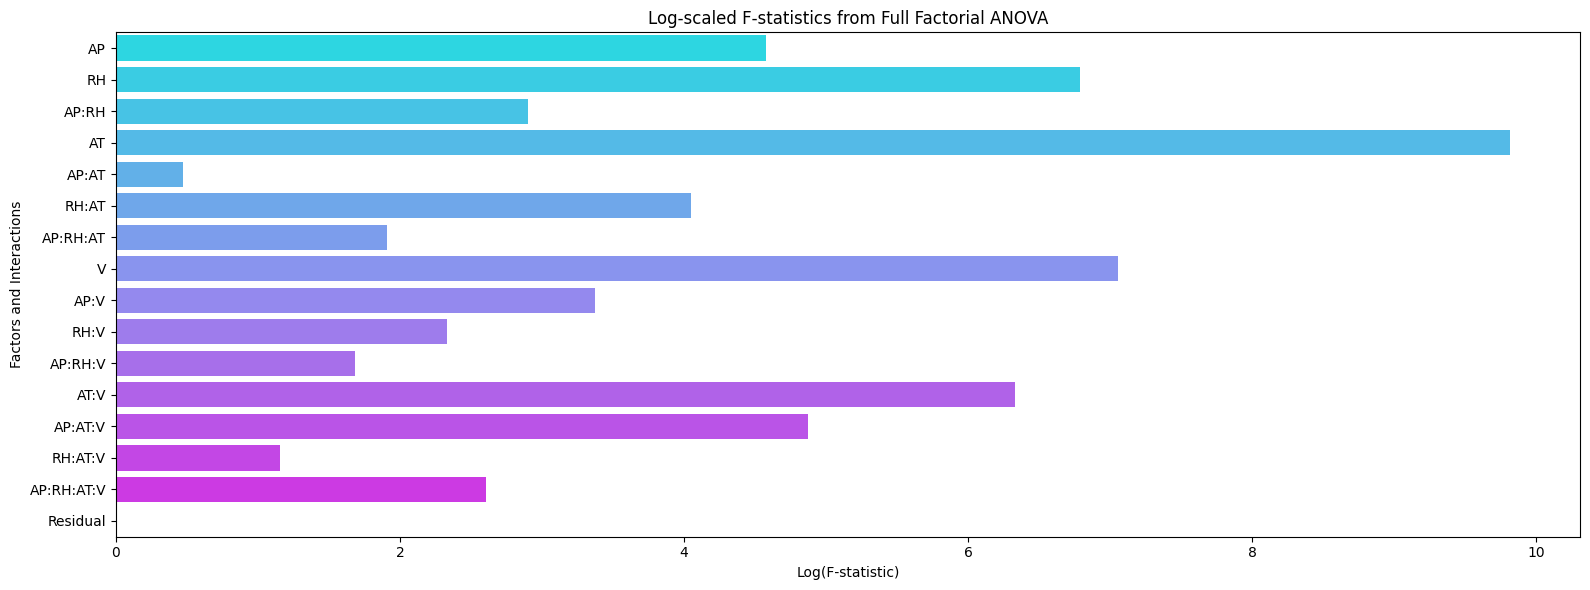

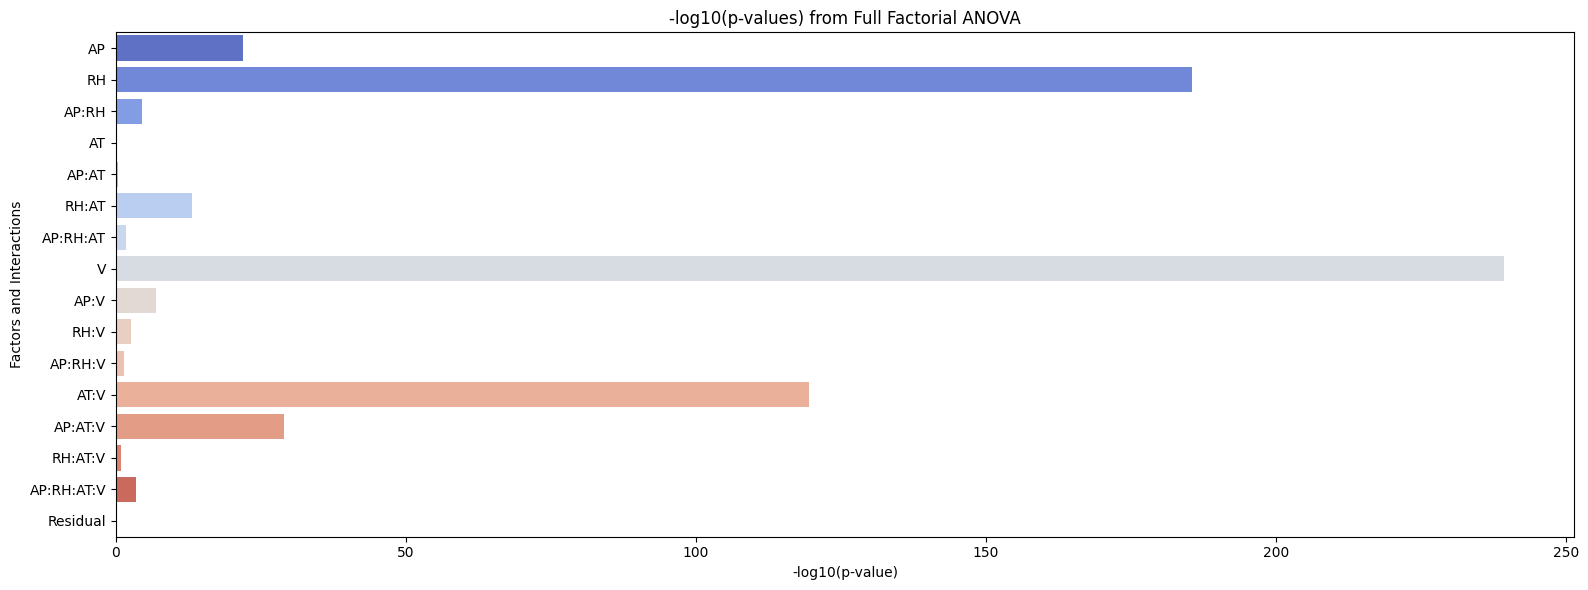

In [25]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fit the full factorial model
formula = 'PE ~ AP * RH * AT * V'
model = ols(formula, data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Extract the F-statistic values and p-values
anova_results = anova_table[['F', 'PR(>F)']].reset_index()
anova_results.columns = ['Factor', 'F_statistic', 'p_value']

# Apply log transformations
anova_results['log_F_statistic'] = np.log1p(anova_results['F_statistic'])  # Log scale for F-statistic
anova_results['neg_log_p_value'] = -np.log10(anova_results['p_value'])  # Log scale for p-value

# Plot log-scaled F-statistics in a wider figure
plt.figure(figsize=(16, 6))
sns.barplot(x='log_F_statistic', y='Factor', data=anova_results, palette='cool')
plt.title("Log-scaled F-statistics from Full Factorial ANOVA")
plt.xlabel("Log(F-statistic)")
plt.ylabel("Factors and Interactions")
plt.tight_layout()
plt.show()

# Plot -log10(p-values) in a separate, wider figure
plt.figure(figsize=(16, 6))
sns.barplot(x='neg_log_p_value', y='Factor', data=anova_results, palette='coolwarm')
plt.title("-log10(p-values) from Full Factorial ANOVA")
plt.xlabel("-log10(p-value)")
plt.ylabel("Factors and Interactions")
plt.tight_layout()
plt.show()

## High log10 p value = lower raw p vale (greater significance)
#### (missing bar graphs for AT and AP:AT)
# avoid high log10 pvalue combinations

### high p values > 0.05
### AP:AT and RH:AT:V

Higher bars on the plot (larger values of -log10(p-value)) indicate smaller p-values, which means higher significance.

Lower bars (closer to 0) mean larger p-values, which indicate lower significance.

# OLS Regression Tests - Full Variables vs Reduced

In [26]:
import statsmodels.api as sm

# Define the features and target variable
X = df[['AP', 'RH', 'AT', 'V']]
y = df['PE']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:04:04   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

## The null hypothesis of F-test states that 
## the reduced model fits the data as well as the full model.
## Instead of just looking at individual significance, consider overall model performance metrics (like R-squared, RMSE, or MAE).
## These give a better picture of how well the model predicts the target variable.

In [27]:
# Fit a reduced model (e.g., excluding one or more predictors)
X_reduced = df[['RH']]  # Example of a reduced model
X_reduced = sm.add_constant(X_reduced)
reduced_model = sm.OLS(y, X_reduced).fit()

# Perform an F-test
f_test = model.compare_f_test(reduced_model)
print("F-test statistic:", f_test[0])
print("p-value:", f_test[1])

F-test statistic: 34725.18230012573
p-value: 0.0


 p-value near zero =  the reduced model does not adequately capture the variance in the target variable (PE) compared to the full model.

In [28]:
#test all reduced models
import pandas as pd
import statsmodels.api as sm
import itertools

# Define the features and target variable
X = df[['AP', 'RH', 'AT', 'V']]
y = df['PE']

# Add a constant to the full model
X_full = sm.add_constant(X)
full_model = sm.OLS(y, X_full).fit()

# Print the summary of the full model
print("Full Model Summary:")
print(full_model.summary())
print("\n")

# Generate all combinations of feature variables
features = X.columns
results = []

for i in range(1, len(features) + 1):
    for combo in itertools.combinations(features, i):
        # Define the reduced model using the combination of features
        X_reduced = X[list(combo)]
        X_reduced = sm.add_constant(X_reduced)
        reduced_model = sm.OLS(y, X_reduced).fit()
        
        # Perform the F-test
        f_test_result = full_model.compare_f_test(reduced_model)
        
        # Store the results
        results.append({
            'Features': combo,
            'F-statistic': f_test_result[0],
            'p-value': f_test_result[1],
            'Reduced Model Summary': reduced_model.summary()
        })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df[['Features', 'F-statistic', 'p-value']])

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:04:04   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749

Threshold: A condition number above 30 often suggests potential multicollinearity issues, and values greater than 100 or 1000 indicate serious problems.

# Our condition number is: 213,000

# VIF scores:

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  Feature        VIF
0      AP  66.618618
1      RH  40.704756
2      AT  39.157705
3       V  74.969127


## If VIF values are high (typically above 10), it indicates multicollinearity. 
## Consider removing or combining features that are highly correlated with each other.

Feature Transformation:

Sometimes, transforming features (e.g., taking the logarithm or scaling) can help alleviate multicollinearity issues.
Principal Component Analysis (PCA):

PCA can be used to reduce dimensionality and create uncorrelated features from your correlated predictors. This can help mitigate multicollinearity while retaining the variance of the data.
Regularization Techniques:

Consider using regularized regression techniques like Lasso or Ridge regression, which can handle multicollinearity more effectively by adding a penalty term to the loss function.

In cases of high collinearity, models using techniques like Lasso or Ridge regression can improve interpretability and performance by focusing on the most important features, even if some individual features are not statistically significant.

Remove Highly Correlated Variables:

Identify and remove one or more variables that are highly correlated with others. You can base this decision on the correlation matrix or consider the importance of each variable to your analysis.

## Variable removal with VIF check

In [30]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define a function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Define the features and target variable
X = df[['AP', 'RH', 'AT', 'V']]
y = df['PE']

# Iteratively remove features with high VIF
while True:
    vif_data = calculate_vif(X)
    max_vif = vif_data['VIF'].max()
    
    # Check if max VIF is above the threshold (10)
    if max_vif > 10:
        # Get the feature with the highest VIF
        feature_to_remove = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
        print(f"Removing feature: {feature_to_remove} with VIF: {max_vif}")
        X = X.drop(columns=[feature_to_remove])
    else:
        break

# Final VIF after removals
final_vif_data = calculate_vif(X)
print("\nFinal VIF values after removals:")
print(final_vif_data)

Removing feature: V with VIF: 74.96912742501162
Removing feature: AP with VIF: 64.59515215774752

Final VIF values after removals:
  Feature       VIF
0      RH  4.413538
1      AT  4.413538


##  If your model has good predictive accuracy (e.g., low RMSE or high $R^2$ in cross-validation),
## it suggests that it captures the relationships effectively, despite multicollinearity.

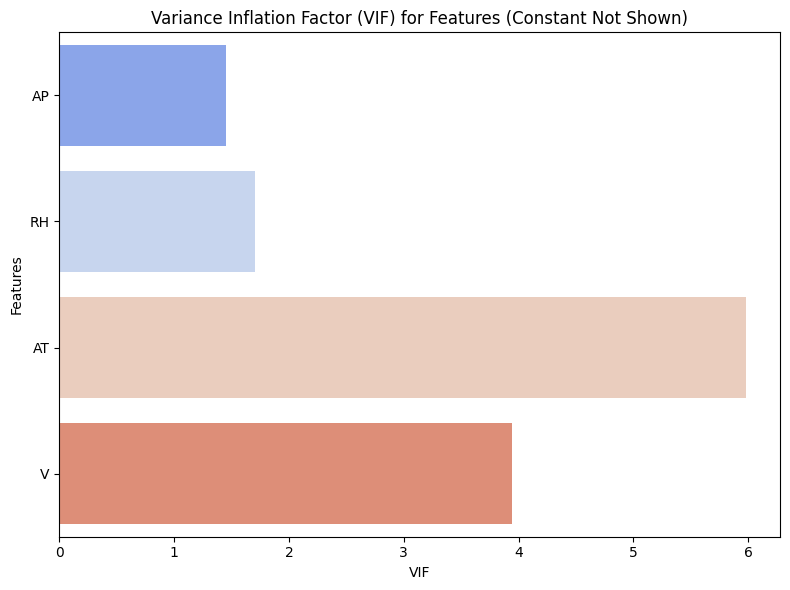

In [31]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature variables (AP, RH, AT, V)
X = df[['AP', 'RH', 'AT', 'V']]

# Add a constant for the intercept in the linear regression
X = sm.add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out the constant from the DataFrame
vif = vif[vif["Feature"] != "const"]

# Plot VIF values as a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='VIF', y='Feature', data=vif, palette='coolwarm')
plt.title("Variance Inflation Factor (VIF) for Features (Constant Not Shown)")
plt.xlabel("VIF")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## Caution: (AT) VIF between 5 and 10: May indicate moderate multicollinearity. 
## It’s worth checking, but it may not be a major concern unless it’s causing issues with model stability.

VIF$(X_i)$=1 / 1- $R_i^{2}$


Regression Setup: For each independent variable $X_i$, you treat it as the dependent variable and regress it on all other independent variables (excluding $X_i$)



 Fitting the Model: A linear regression is performed, where XiX_iXi is predicted using the other independent variables. The regression equation might look like this:

R^2 is found when fitting a linear regression model

The value of R^2 ranges from 0 to 1, where:
<br>•	R^2 = 1 means perfect prediction (high multicollinearity with other features).
<br>•	R^2 =0 means no relationship between $X_i$ and the other variables.

Calculate R2R^2R2: After fitting the regression, R2R^2R2 is calculated using the formula:
R2=1−SSresSStotR^2 = 1 - \frac{\text{SS}_{\text{res}}}{\text{SS}_{\text{tot}}}R2=1−SStotSSres
•	SSres\text{SS}_{\text{res}}SSres (residual sum of squares): This measures the discrepancy between the actual values of XiX_iXi and the predicted values from the regression model.
•	SStot\text{SS}_{\text{tot}}SStot (total sum of squares): This measures the total variability in XiX_iX


Unstable Coefficients: When features are highly correlated, it becomes difficult to isolate the individual effect of each predictor on the target variable. This leads to unstable and sensitive coefficients that can change drastically with small changes in the data.

Inflated Standard Errors: High collinearity increases the standard errors of the regression coefficients, which makes it harder to determine if predictors are statistically significant. This can lead to false conclusions about which features are important.

Overfitting: Multicollinearity can cause the model to overfit the data, as it may rely heavily on correlated predictors, leading to poor generalization to new, unseen data.

Reduced Interpretability: When predictors are highly correlated, it’s hard to determine which feature is truly driving the prediction. This reduces the interpretability of the model.

If any VIF values are greater than 10, it indicates high multicollinearity.

A value less than 5 suggests that the variable is not strongly correlated with the other predictors, so it's safe to keep in the model.

Between 5 and 10 Indicates moderate multicollinearity. It's not necessarily a problem, but you should carefully check the variables that have VIF in this range to ensure that multicollinearity isn't introducing significant issues into the model.

To check which variables AT (Ambient Temperature) shares collinearity with, you can calculate the correlation matrix and pairwise correlation coefficients between all variables in your dataset. This will show how strongly AT is correlated with other features.

Variance Inflation Factor (VIF): While correlation shows direct pairwise relationships, VIF can indicate collinearity by taking all other variables into account. To see how AT contributes to multicollinearity with others:

## VIF without constant

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Define the independent variables (features)
X = df[['AP', 'RH', 'AT', 'V']]

# Calculate VIF for each variable - no constant
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

  Variable        VIF
0       AP  66.618618
1       RH  40.704756
2       AT  39.157705
3        V  74.969127


Correlation Matrix: The higher the correlation between AT and another variable (closer to ±1), the more likely they are collinear.

VIF: If you observe high VIF values (above 5 or 10) for variables other than AT, this indicates multicollinearity between those variables and AT.

## 95% Confidence interval for population mean:

In [33]:
import numpy as np
from scipy import stats

# Step 1: Extract the 'PE' column
values = df['PE']

# Step 2: Calculate the sample mean and sample standard deviation
sample_mean = np.mean(values)
sample_std = np.std(values, ddof=1)  # Sample standard deviation
n = len(values)  # Sample size

# Step 3: Set confidence level and corresponding z-value
confidence_level = 0.95
z_value = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # For 95% CI

# Step 4: Calculate margin of error
margin_of_error = z_value * (sample_std / np.sqrt(n))

# Step 5: Calculate confidence interval
lower_bound = sample_mean - margin_of_error
upper_bound = sample_mean + margin_of_error

# Output the result
print(f"95% Confidence Interval for the mean of PE: ({lower_bound}, {upper_bound})")

95% Confidence Interval for the mean of PE: (454.023034240424, 454.7069845722851)


is this comparable to worldwide statistics?

# Outlier removal analysis

 (b) Z-scores for detecting outliers numerically:

In [35]:
from scipy.stats import zscore

# Calculate Z-scores for each feature and target variable
df_z = df[['AP', 'RH', 'AT', 'V', 'PE']].apply(zscore)

# Combine original data with Z-scores
df_combined = df[['AP', 'RH', 'AT', 'V', 'PE']].copy()
for col in df_combined.columns:
    df_combined[f'{col}_Z'] = df_z[col]

# Identify outliers (absolute Z-score > 3)
outliers = (df_z.abs() > 3).any(axis=1)

# Show rows with outliers, including Z-scores
df_outliers = df_combined[outliers]
# print("Outliers detected with Z-scores:")
# print(df_outliers)

In [36]:
# Without outliers (absolute Z-score <= 3)
df_z = df[['AP', 'RH', 'AT', 'V', 'PE']].apply(zscore)
no_outliers = df[(df_z.abs() <= 3).all(axis=1)]

# Compare summary statistics
print("Original Data:")
print(df.describe())

print("\nWithout Outliers:")
print(no_outliers.describe())

Original Data:
                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000

Without Outliers:
                AT            V           AP           RH           PE
count  9510.000000  9510.000000  9510.000000  9510.000000  9510.000000
mean     19.692802    54.366760  1013.192105    73.324603   454.269644
std       7.433565    12.701365     5.792225    14.575318    17.037027
min       1.810000    25.360000   995.45000

## removing outliers = only small effect to mean or std dev

# K means cluster choice:

Use clustering techniques (like K-means) to identify whether outliers form distinct clusters. 

If they do, it suggests the outliers might be valid data points, representing a separate class.

### elbow method for choosing best cluster

This method evaluates the sum of squared distances between points and their assigned cluster center (inertia). As the number of clusters increases, the inertia decreases. The best number of clusters is at the "elbow" point where the inertia begins to level off.

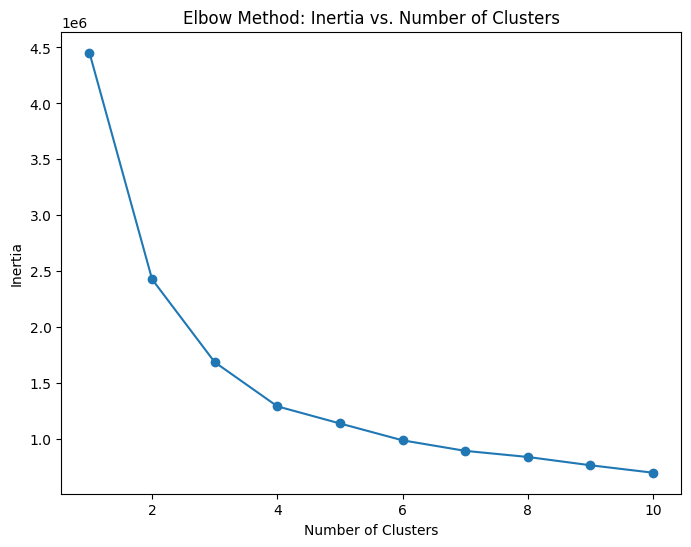

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the range for number of clusters
inertia = []
cluster_range = range(1, 11)  # You can adjust the range

# Calculate inertia for different numbers of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[['AP', 'RH', 'AT', 'V']])  # Use your independent variables
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### sillhouette score

The Silhouette Score measures how similar a point is to its own cluster compared to other clusters.

The score ranges from -1 to 1, with higher values indicating better-defined clusters.

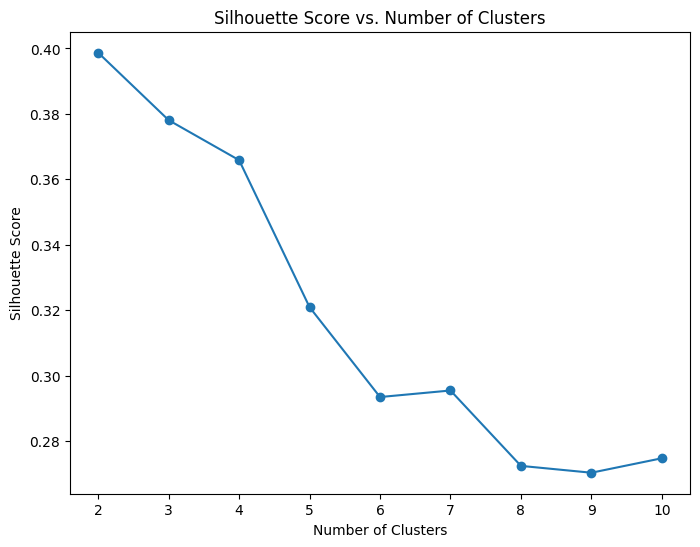

In [38]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define the range of clusters, starting from 2
cluster_range = range(2, 11)  # Adjust the range if needed

# Calculate silhouette score for different numbers of clusters
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df[['AP', 'RH', 'AT', 'V']])
    silhouette_avg = silhouette_score(df[['AP', 'RH', 'AT', 'V']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# K means clustering explanation:

After assigning individual points, the cluster centroid (average position of all the data points within that cluster) is updated to be the mean of all points in that cluster.

For example, if a cluster has 3 points with coordinates (x1,y1), (x2,y2), and (x3,y3), the centroid is found by averaging each coordinate.

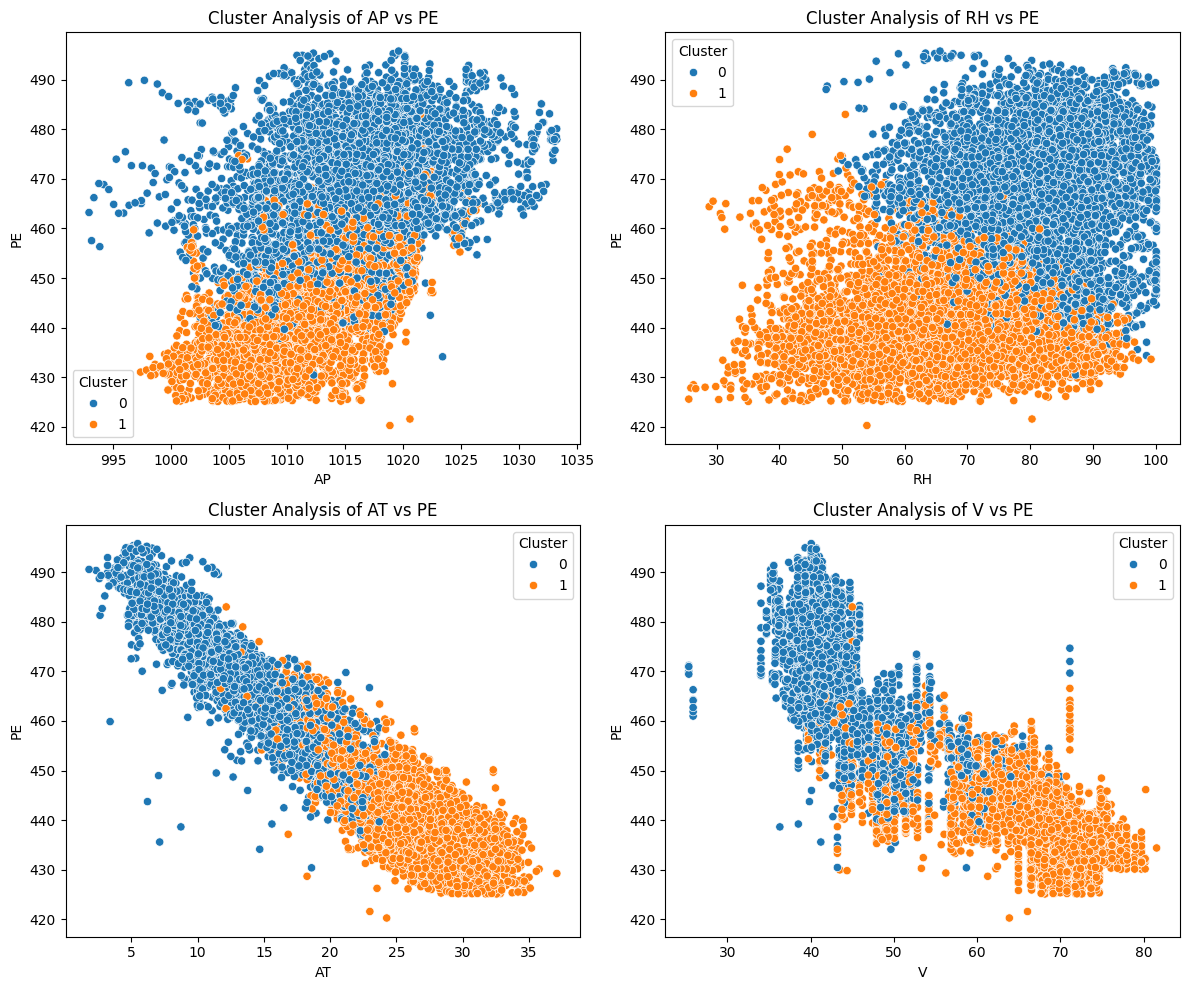

In [39]:

# Perform K-means clustering (k=4 as per your requirement)
kmeans = KMeans(n_clusters=2)
df['Cluster'] = kmeans.fit_predict(df[['AP', 'RH', 'AT', 'V']])

# List of feature variables
features = ['AP', 'RH', 'AT', 'V']

# Set up a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()  # Flatten the array for easier indexing

# Loop through features to create individual scatter plots
for i, indep in enumerate(features):
    sns.scatterplot(x=indep, y='PE', hue='Cluster', data=df, ax=axs[i])
    axs[i].set_title(f'Cluster Analysis of {indep} vs PE')
    axs[i].set_xlabel(indep)
    axs[i].set_ylabel('PE')

# Adjust layout
plt.tight_layout()
plt.show()


A very scattered cluster indicates high variance within the cluster, meaning that the individual data points are far from the cluster centroid and from each other, 

resulting in a larger spread in their distances, which mathematically reflects greater uncertainty and less homogeneity in that group.

## Well-separated clusters indicate that the features are discriminating the data well.
## Better separation = Algorithim will be better at finding boundaries in a model.
##  AP and V are most scattered

<u><b>Data Points (Observations):</u></b> Each point corresponds to an individual observation (or data record) in the dataset.

The position of the point is determined by the values of its features (variables).

For example, in a 2D plot, each point has two coordinates (e.g., x and y) representing two features, while in higher dimensions, the plot shows a projection of the data.


<u><b>Cluster Assignment:</u></b> After running KMeans, each data point is assigned to a cluster based on its proximity to the cluster centroids.

Points that are closer together are considered to belong to the same cluster. Typically, different colors or markers are used on the plot to show which points belong to which clusters.

In [40]:
# Calculate mean of features for each cluster
cluster_summary = df.groupby('Cluster')[['AT', 'PE']].mean()
print(cluster_summary)

                AT          PE
Cluster                       
0        13.720628  467.365186
1        25.732485  441.034600


#### Lasso Output:
Best alpha: The alpha value that results in the lowest MSE.

Best MSE score: The best (lowest) cross-validated MSE score corresponding to the optimal alpha.

This process helps you choose the best regularization strength for your Lasso regression model on your dataset, minimizing the MSE.

In [41]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define features (X) and target (y)
X = df[['AP', 'AT', 'RH', 'V']]  # Features
y = df['PE']  # Target

# Step 1: Set up the pipeline (scaling + Lasso regression)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 2: Scale features
    ('lasso', Lasso())             # Step 3: Apply Lasso regression
])

# Step 4: Define the grid of alpha values to search over
param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}  # Range of alphas to tune

# Step 5: Set up the GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)

# Step 6: Fit the grid search to the data
grid_search.fit(X, y)

# Step 7: Output the best alpha value and the corresponding MSE score
print("Best alpha:", grid_search.best_params_['lasso__alpha'])
print("Best MSE score:", -grid_search.best_score_)

Best alpha: 0.001
Best MSE score: 20.80347511226623


https://scikit-learn.org/stable/modules/cross_validation.html

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Define the feature matrix X and target vector y
X = df[['AP', 'AT', 'RH', 'V']]  # Features
y = df['PE']  # Target

# Define the linear regression model
model = LinearRegression()

# 5-fold cross-validation with negative mean squared error
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive for interpretation
mse_scores = - scores

print("Cross-validation MSE scores:", mse_scores)
print("Mean MSE score:", mse_scores.mean())

Cross-validation MSE scores: [20.69137771 22.95480205 19.59126147 20.78579791 19.99408646]
Mean MSE score: 20.80346512042863


These values represent the MSE for each of the 5 cross-validation splits.

The fact that the MSE scores across the 5 folds are similar (ranging from about 19.59 to 22.95) suggests that the model is relatively stable and performs consistently across different subsets of your data.

Aim to reduce the MSE because it measures prediction error. 

#### Output the fold number with MSE values:

In [43]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume df is your dataframe and you're using AP, AT, RH, V as features
X = df[['AP', 'AT', 'RH', 'V']]  # Features
y = df['PE']  # Target

# Step 1: Apply KMeans clustering (choose number of clusters k)
kmeans = KMeans(n_clusters=3, random_state=42)
X['cluster'] = kmeans.fit_predict(X)

# Step 2: Scale the data (optional, depends on the need for regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Perform K-fold cross-validation on the regression model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()

# Step 4: Store MSE scores for each fold
mse_scores = []
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = np.mean((y_pred - y_test) ** 2)
    mse_scores.append(mse)

# Step 5: Identify the fold with an MSE close to 19
for i, mse in enumerate(mse_scores):
    print(f"Fold {i+1} MSE: {mse}")
    if np.isclose(mse, 19, atol=0.5):  # Adjust tolerance if needed
        print(f"Selected fold: {i+1} with MSE of {mse}")
        selected_fold = i+1

Fold 1 MSE: 19.59060042123448
Fold 2 MSE: 21.067128054380575
Fold 3 MSE: 22.800036874150244
Fold 4 MSE: 19.67466261188024
Fold 5 MSE: 20.906292863464113


### Train from specific fold (not common)

In [44]:
from sklearn.model_selection import KFold
import numpy as np

# Define features (X) and target (y)
X = df[['AP', 'AT', 'RH', 'V']].values  # Features
y = df['PE'].values  # Target

# Step 1: Perform KFold split to isolate Fold 1
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = list(kf.split(X))

# Step 2: Select Fold 1 (first fold) data
train_index, test_index = splits[0]  # Fold 1
X_train, y_train = X[train_index], y[train_index]

# Step 3: Train the model on Fold 1 training data
pipeline.fit(X_train, y_train)

# Step 4: Get model coefficients and intercept (optional)
print("Model coefficients from Fold 1:", pipeline.named_steps['linear_reg'].coef_)
print("Model intercept from Fold 1:", pipeline.named_steps['linear_reg'].intercept_)

KeyError: 'linear_reg'

### Train from full dataset (preferred method)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define features (X) and target (y)
X = df[['AP', 'AT', 'RH', 'V']]  # Features
y = df['PE']  # Target

# Step 1: Set up a pipeline for scaling + linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('linear_reg', LinearRegression())  # Linear regression
])

# Step 2: Train on the entire dataset
pipeline.fit(X, y)

# Step 3: Get model coefficients and intercept (optional)
print("Model coefficients:", pipeline.named_steps['linear_reg'].coef_)
print("Model intercept:", pipeline.named_steps['linear_reg'].intercept_)